##### """
Implementing Jayasinghe et al. 2021 method for identifying variable star periodicities.
This is after the cuts implemented by Jayasinghe et al. 2021 to identify potential variabilities.

The procedure is as follows:

1. Run a GLS periodogram from 0.05 days to 1000 days. Keep the peaks that (a) have S/N of peaks > 5
(figure out how to quantify this), and (b) FAP < 10^-10 and (c) have power > 0.25
2. Run MHAOV, initializing N(harmonic) = 2. Keep peaks with S/N > 5 (figure out how to quantify this)
3. Run BLS, initializing 200 phase bins, and a min-max transit from 0.1-0.3 in phase. Keep
 powers<0.3.
4. Run PDM with the top 5 peaks from GLS, MHAOV, and BLS (15 peaks total). Select the best peak from
 this for fit
"""

In [4]:
import sys
!{sys.executable} -m pip install P4J

In [2]:
import sys
!{sys.executable} -m pip install astrobase

In [3]:
!{sys.executable} -m pip install pwkit

In [27]:
from PyAstronomy.pyasl import foldAt
#import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
import pandas as pd
import scipy.optimize as opt
import P4J
import astrobase
import pwkit

import matplotlib.pyplot as plt
%matplotlib inline

In [28]:

def period_fold(t, y, freq):

    phases = foldAt(t, period=1/freq)
    print(phases.max())
    sortIndi = np.argsort(phases)
    phases = phases[sortIndi]
    y = y[sortIndi]

    plt.plot(phases,y, 'bp')
    # plt.plot(t_fit, np.sin(t_fit*best_frequency))
    plt.title("Frequency: " + str(freq) + ", Period: " + str(1/freq))
    plt.show()
    
    return phases, y

def fit_peaks(p, t, f, df, lsg):
    phases = foldAt(t, p)
    print("PERIOD: ", p)

    sortIndi = np.argsort(phases)

    phases = phases[sortIndi]
    fg1 = f[sortIndi]
    
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)


    plt.errorbar(phases, fg1, yerr = df, fmt = "k.")

    t_fit = np.linspace(0, p, 100)
    y_fit = lsg.model(t_fit, 1/p)
    
    plt.plot(t_fit/p, y_fit)
    plt.xlabel("Phase"), plt.ylabel("Flux")
    plt.title("Phase Folded Best Fit at Period " + str(round(p, 3)))
    # plt.xlim(0, 0.7)
    plt.show()

    y_fit = lsg.model(t, 1/p)
    
def identify_peaks(frequency, power, n=20):
    """
    Finds the top n peaks in a periodogram given the frequency list, and 
    power list. Returns the top n frequencies and powers.
    """
    
    maxes = [np.where(power==sorted(power, reverse=True)[i]) for i in range(n)] # Find the indexes where power is sorted maximum to minimum.
    
    best_freqs = []
    powers = []
    faps = []
    
    for i in range(len(maxes)):
        # find the power and frequency at the max indices
        p_ = power[maxes[i][0][0]] 
        f_ = frequency[maxes[i][0][0]]
        best_freqs.append(f_)
        powers.append(p_)
        
    return best_freqs, powers


In [87]:
def get_band_ts(df, band):
    """
    returns the DataFrame Series for time, flux, and uncertainity given the formatted DataFrame. 
    The DataFrame must be formatted to have "band title" for every column, such as "g BJD" or "z dy"
    """
    return df[band + " MJD"], df[band + " MAG"], df[band + " MAGERR"]

bands = ["g", "r", "i", "z"]

candidates_df = pd.read_csv("Updated Candidate List.csv")
candidates = candidates_df["Candidate"]

candidate = candidates[1]
folder_ext = "data/"
df = pd.read_csv(folder_ext + candidate + " 1.csv")

print(candidate, df)

band = "z"

# Exclude data below 5th and above 95th percentile to avoid outliers.

DC21bcrfk      Unnamed: 0         g MJD      g MAG  g MAGERR         r MJD      r MAG  \
0             0  59746.229280  20.743695  0.098592  59746.230725  20.186075   
1             1  59746.221824  20.798199  0.102358  59746.223276  19.691984   
2             2  59714.312414  21.473503  0.118222  59714.313871  20.640682   
3             3  59714.303520  21.168424  0.087786  59331.333774  18.971615   
4             4  59714.299802  21.068644  0.085628  59331.330082  18.934880   
..          ...           ...        ...       ...           ...        ...   
207         207           NaN        NaN       NaN           NaN        NaN   
208         208           NaN        NaN       NaN           NaN        NaN   
209         209           NaN        NaN       NaN           NaN        NaN   
210         210           NaN        NaN       NaN           NaN        NaN   
211         211           NaN        NaN       NaN           NaN        NaN   

     r MAGERR         i MJD      i MAG  i

<ErrorbarContainer object of 3 artists>

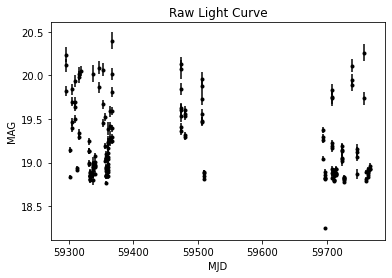

In [31]:
# Exclude data below 5th and above 95th percentile to avoid outliers.
# print(df)
cols = [band + ' MAG'] # one or more
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


t, f, dg = get_band_ts(df, band)

t = np.array(t.dropna())
f = np.array(f.dropna())
dg = np.array(dg.dropna())

# print(len(t))
plt.title("Raw Light Curve")
plt.xlabel("MJD")
plt.ylabel("MAG")
plt.errorbar(t, f, dg, fmt="k.")

Sorry, no significant peaks in this periodogram.
Displaying the full periodogram and best fit peak: 


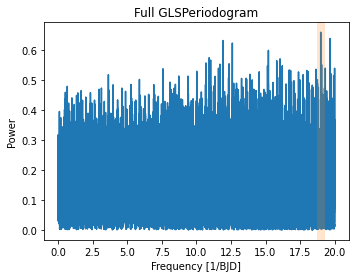

PERIOD:  0.0526651703271836


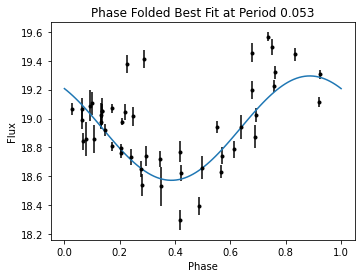

In [9]:
# Compute the GLS on Jayasinghe's frequency limits.
frequency_min = 1/1000
frequency_max = 1/0.05

ls = LombScargle(t, f, dg)
frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
mean_power = np.mean(power)
# print(mean_power, len(frequency))
# Only keeping peaks with S/N > 5

sn_peaks = {"Frequency": [], "Power": [], "FAP": []}

for i in range(len(power)):
    freq = frequency[i]
    powe = power[i]
    if powe/mean_power >= 5:
        sn_peaks["Frequency"].append(freq)
        sn_peaks["Power"].append(powe)
        sn_peaks["FAP"].append(ls.false_alarm_probability(powe))
        
if len(sn_peaks["Frequency"]) == 0:
    print("Sorry, no significant peaks in this periodogram.\nDisplaying the full periodogram and best fit peak: ")
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(frequency, power)
    ymin, ymax = ax.get_ylim()
    ax.plot([frequency[np.argmax(power)], frequency[np.argmax(power)]], [ymin, ymax], linewidth=8, alpha=0.2)
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel('Frequency [1/BJD]')
    ax.set_ylabel('Power')
    plt.title('Full GLSPeriodogram')
    plt.show()
    ax = fig.add_subplot(1, 2, 2)
    fit_peaks(1/frequency[np.argmax(power)], t, f, dg, ls)
    
    ls_best_freqs, ls_best_power = [], []

else:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(sn_peaks["Frequency"], sn_peaks["Power"])
    ymin, ymax = ax.get_ylim()
    ax.plot([sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])]], [ymin, ymax], linewidth=8, alpha=0.2)
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel('Frequency [1/BJD]')
    ax.set_ylabel('Power')
    plt.title('GLSPeriodogram')
    plt.grid()

    fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)

    # Finding top 5 frequencies

    ls_best_freqs, ls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=5)

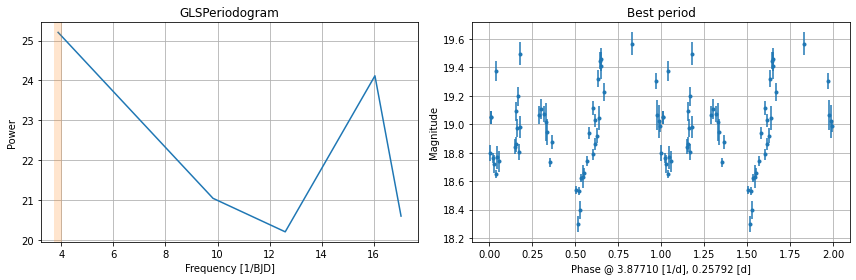

In [10]:
# Compute MHAOV based on Jayasinghe's initialization.

N_harm = 2
my_per = P4J.periodogram(method='MHAOV')
my_per.set_data(np.array(t), np.array(f), np.array(dg), Nharmonics = N_harm)
my_per.frequency_grid_evaluation(fmin=frequency_min, fmax=frequency_max, fresolution=1e-3)
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies


# Find S/N > 5 signals

mean_power = np.mean(per)
sn_peaks = {"Frequency": [], "Power": []}

for i in range(len(per)):
    fre = freq[i]
    powe = per[i]
    if powe/mean_power >= 5:
        sn_peaks["Frequency"].append(fre)
        sn_peaks["Power"].append(powe)
        

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(sn_peaks["Frequency"], sn_peaks["Power"])
ymin, ymax = ax.get_ylim()
ax.plot([sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/BJD]')
ax.set_ylabel('Power')
plt.title('GLSPeriodogram')
plt.grid()

# fig = plt.figure(figsize=(12, 4))
# ax = fig.add_subplot(1, 2, 1)
# ax.plot(freq, per)
# ymin, ymax = ax.get_ylim()
# ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
# ax.set_ylim([ymin, ymax])
# ax.set_xlabel('Frequency [1/MJD]')
# ax.set_ylabel('QMI Periodogram')
# plt.title('Periodogram')
# plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(t, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]), 
            np.concatenate([f[idx], f[idx]]),
            np.concatenate([dg[idx], dg[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout();


# Finding top 5 frequencies

mhaov_best_freqs, mhaov_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=5)

In [1]:
# BLS periodogram implementation
from astrobase import periodbase

phase_bins = 200
min_duration = 0.1
max_duration = 0.3

# bls_dict = abls.bls_serial_pfind(t, f, dg, 
#             nphasebins = phase_bins, mintransitduration=min_duration, 
#             maxtransitduration = max_duration, 
#             startp = frequency_min, endp = frequency_max) 


bls_dict = periodbase.bls_parallel_pfind(np.array(t), np.array(f), np.array(dg), nphasebins = phase_bins,
            mintransitduration=min_duration, 
            maxtransitduration = max_duration, 
            startp = frequency_min, endp = frequency_max, autofreq=False)


# bls_dict = periodbase.bls_serial_pfind(t, f, dg)

frequency = bls_dict["frequencies"]
power = bls_dict["lspvals"]

best_period = bls_dict["bestperiod"]
best_power = bls_dict["bestlspval"]

# print(bls_dict["nphasebins"])


9999500 22
PERIOD:  2.965599051008304


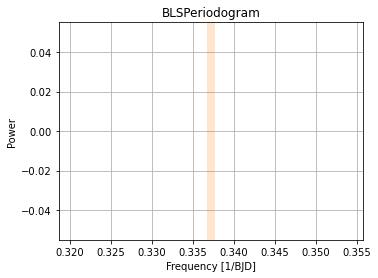

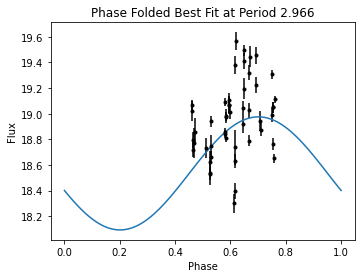

In [12]:
# Continuation of BLS periodogram, plotting perioodgram and model

sn_peaks = {"Frequency": [], "Power": []}

for i in range(len(power)):
    freq = frequency[i]
    powe = power[i]
    if powe >= 0.3: # Fix this relation... don't know what's up. Power is in the 1000s.
        sn_peaks["Frequency"].append(freq)
        sn_peaks["Power"].append(powe)

print(len(frequency), len(sn_peaks["Frequency"]))

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(sn_peaks["Frequency"], sn_peaks["Power"])
ymin, ymax = ax.get_ylim()
ax.plot([sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/BJD]')
ax.set_ylabel('Power')
plt.title('BLSPeriodogram')
plt.grid()

fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)

# Finding top 5 frequencies

bls_best_freqs, bls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=5)

In [13]:
# Compute PDM based on Jayasinghe's paper. Note that candidate DC21badcl would be flagged because its GLS period did not match the MHAOV or BLS period.
from pwkit import pdm
nbins = 20

periods = [*list(1/np.array(ls_best_freqs)), *list(1/np.array(mhaov_best_freqs)), *list(1/np.array(bls_best_freqs))]

pdm_dict = pwkit.pdm.pdm(t, f, dg, periods, nbin=nbins)

theta = pdm_dict[0]

PERIOD:  0.25792473554611206
THETA:  0.41821616053713195
PERIOD:  0.062320828437805176
THETA:  0.43839570991662125
PERIOD:  0.10176046192646027
THETA:  0.4436947668266194
PERIOD:  0.05865584686398506
THETA:  0.49682056475007896
PERIOD:  0.0793619304895401
THETA:  0.5855300828792576


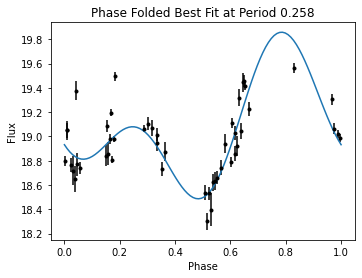

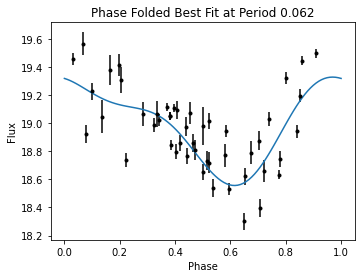

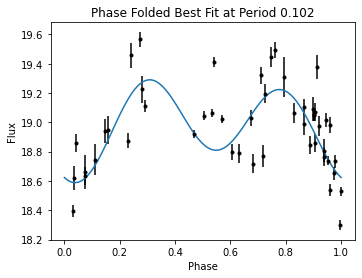

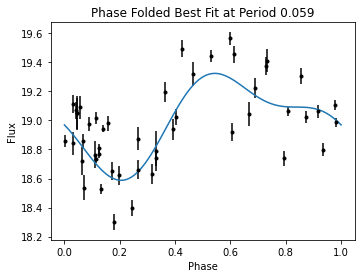

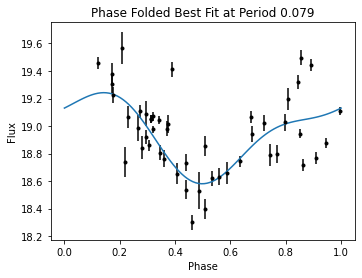

In [14]:
# We want the minimum theta statistic to find the best periods.
# I will sort the periods by increasing theta statistic, 
# then plot the top 5 phase folded graphs according to the statistic.
n = 5
ls = LombScargle(t, f, dg, nterms = 2)
indices = np.argsort(theta)
theta_sorted = theta[indices]
periods_sorted = np.array(periods)[indices]
plt.close()
for i in range(n):
    fit_peaks(periods_sorted[i], t, f, dg, ls)
    print("THETA: ", theta_sorted[i])

In [ ]:
# Run fits for each band from top period for all bands

pers = [0.2, 0.2471027374267578, 0.21194972097873688,  0.21194639765816328, 
        0.19793155329450854, 0.12585264444351196, 0.20263835787773132, 3.124023914337158]

pers = [0.6453082759220174, 0.21954700125452684, 0.6215040683746338, 0.28691935539245605, 0.3698224723339081, 2.474022626876831]
df = pd.read_csv("data/" + candidate + ".csv")
bands = ["g", "r", "i", "z"]
for band in bands:
    cols = [band + ' Flux'] # one or more
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    df2 = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


    t, f, dg = get_band_ts(df2, band)

    t = np.array(t.dropna())
    f = np.array(f.dropna())
    dg = np.array(dg.dropna())
    ls = LombScargle(t, f, dg, nterms = 1)
    frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
    print(ls.false_alarm_probability(power[np.argmax(power)]))
    for p in pers:
        fit_peaks(p, t, f, dg, ls)

In [47]:
from functools import wraps
import logging

def suspendlogging(func):
    @wraps(func)
    def inner(*args, **kwargs):
        log = logging.getLogger()
        previousloglevel = log.getEffectiveLevel()
        try:
            return func(*args, **kwargs)
        finally:
            log.setLevel(previousloglevel)
    return inner

In [52]:
"""
Looking good. Now making this reproducable so it can be done autonomously:
"""

phase_bins = 200
min_duration = 0.1
max_duration = 0.3
frequency_min = 1/1000
frequency_max = 1/0.05
N_harm = 2
num = 5
    
from astrobase import periodbase
from pwkit import pdm

# Function to find best GLS peaks:
def gls_peaks(t, y, dy):
    # Compute the GLS on Jayasinghe's frequency limits.
    ls = LombScargle(t, y, dy)
    frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
    mean_power = np.mean(power)
    # print(mean_power, len(frequency))
    # Only keeping peaks with S/N > 5

    sn_peaks = {"Frequency": [], "Power": [], "FAP": []}

    for i in range(len(power)):
        freq = frequency[i]
        powe = power[i]
        if powe/mean_power >= 5:
            # ADDING ANOTHER CONDITIONAL TO MAKE SURE THAT FAP < 10^-10
            if ls.false_alarm_probability(powe) < 10**(-10):
                # print(freq, ls.false_alarm_probability(powe))
                sn_peaks["Frequency"].append(freq)
                sn_peaks["Power"].append(powe)
                sn_peaks["FAP"].append(ls.false_alarm_probability(powe))

    if len(sn_peaks["Frequency"]) < 5:
        n = len(sn_peaks["Frequency"])
    else:
        n = 5
   
    if n == 0:
        print("Sorry, no significant peaks in this periodogram")
        ls_best_freqs, ls_best_power = [], []
        flag = True

    else:
        # fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)

        # Finding top 5 frequencies
        # ls_best_freqs, ls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=n)
        flag = False
        
    return sn_peaks, flag

def mhaov_peaks(t, y, dy):
     # Compute MHAOV based on Jayasinghe's initialization.
    print("COMPUTING MHAOV")

    my_per = P4J.periodogram(method='MHAOV')
    my_per.set_data(np.array(t), np.array(y), np.array(dy), Nharmonics = N_harm)
    my_per.frequency_grid_evaluation(fmin=frequency_min, fmax=frequency_max, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
    freq, per = my_per.get_periodogram()
    fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies


    # Find S/N > 5 signals

    mean_power = np.mean(per)
    sn_peaks = {"Frequency": [], "Power": []}

    for i in range(len(per)):
        fre = freq[i]
        powe = per[i]
        if powe/mean_power >= 5:
            sn_peaks["Frequency"].append(fre)
            sn_peaks["Power"].append(powe)

    # Finding top 5 frequencies
    
    if len(sn_peaks["Frequency"]) < 5:
        n = len(sn_peaks["Frequency"])
    else:
        n = 5
        
    if len(sn_peaks["Frequency"]) < 5:
        num = len(sn_peaks["Frequency"])
        
    if len(sn_peaks["Frequency"]) == 0:
        print("Sorry, no significant peaks in this periodogram")
        mhaov_best_freqs, mhaov_best_power = [], []
        flag = True

    else:
        # fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg, ls)
        mhaov_best_freqs, mhaov_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=n)
        flag = False
        
    return mhaov_best_freqs, mhaov_best_power, flag

@suspendlogging
def bls_peaks(t, y, dy):
    # BLS periodogram implementation
    logger = logging.getLogger()
    logger.setLevel(level=logging.WARNING)
    print("COMPUTING BLS")

    bls_dict = periodbase.bls_parallel_pfind(np.array(t), np.array(y), np.array(dy), nphasebins = phase_bins,
                mintransitduration=min_duration, 
                maxtransitduration = max_duration, 
                startp = frequency_min, endp = frequency_max, autofreq=False)

    frequency = bls_dict["frequencies"]
    power = bls_dict["lspvals"]
    

    sn_peaks = {"Frequency": [], "Power": []}

    for i in range(len(power)):
        freq = frequency[i]
        powe = power[i]
        if powe >= 0.3: # Fix this relation... don't know what's up. Power is in the 1000s.
            sn_peaks["Frequency"].append(freq)
            sn_peaks["Power"].append(powe)

    # Finding top 5 frequencies
    
    if len(sn_peaks["Frequency"]) < 5:
        n = len(sn_peaks["Frequency"])
    else:
        n = 5
        
    if len(sn_peaks["Frequency"]) < 5:
        num = len(sn_peaks["Frequency"])
        
    if len(sn_peaks["Frequency"]) == 0:
        print("Sorry, no significant peaks in this periodogram")
        bls_best_freqs, bls_best_power = [], []
        flag = True
        
    else:
        # fit_peaks(1/sn_peaks["Frequency"][np.argmax(sn_peaks["Power"])], t, f, dg)
        bls_best_freqs, bls_best_power = identify_peaks(sn_peaks["Frequency"], sn_peaks["Power"], n=n)
        flag = False
        
    return bls_best_freqs, bls_best_power, flag
   
def best_pdm(t, y, dy, periods):   
    # Compute PDM based on Jayasinghe's paper. Note that candidate DC21badcl would be flagged because its GLS period did not match the MHAOV or BLS period.
    print("COMPUTING PDM")
    nbins = 20

    pdm_dict = pwkit.pdm.pdm(t, y, dy, periods, nbin=nbins)

    theta = pdm_dict[0]
    indices = np.argsort(theta)
    
    return np.array(periods)[indices]
    
def find_variability(t, y, dy):
    ls_best_freqs, ls_best_power = gls_peaks(t, y, dy)
    mhaov_best_freqs, mhaov_best_power = mhaov_peaks(t, y, dy)
    bls_best_freqs, bls_best_power = bls_peaks(t, y, dy)
    
    periods = [*list(1/np.array(ls_best_freqs)), *list(1/np.array(mhaov_best_freqs)), *list(1/np.array(bls_best_freqs))]
    
    best_periods = best_pdm(t, y, dy, periods)
    
    return best_periods
    
    
def find_common(periods_dictionary, count_level = 2):   
    # First find only unique values for each band. 
    # Then, concatenate the bands and find unique values and their counts for the concatenated list.
    
    dec = 2
    g = np.unique(np.around(np.array(periods_dictionary["g"]), decimals = dec))
    r = np.unique(np.around(np.array(periods_dictionary["r"]), decimals = dec))
    i = np.unique(np.around(np.array(periods_dictionary["i"]), decimals = dec))
    z = np.unique(np.around(np.array(periods_dictionary["z"]), decimals = dec))

    
    # print(g, r, i, z)
    
    conc = np.array(list(g) + list(r) + list(i) + list(z))
    if len(conc) == 0:
        return [], []
    
    else:
        conc_full = np.array(list(periods_dictionary["g"]) + list(periods_dictionary["r"]) + list(periods_dictionary["i"]) + list(periods_dictionary["z"]))

        conc_unique, conc_counts = np.unique(conc, return_counts = True)
        # print(conc, conc_counts, conc_unique)
        counts, unique = (np.array(t) for t in zip(*sorted(zip(conc_counts, conc_unique), reverse = True)))
        counts_ = counts[counts >= count_level]
        unique_ = unique[counts >= count_level]

        total_uniques = []
        total_counts = []
        for i in range(len(unique_)):
            u = unique_[i]
            for c in conc_full:
                if str(u) in str(c):
                    # print(u, c)
                    total_uniques.append(c)
                    total_counts.append(counts_[i])
                    break

        return total_uniques, total_counts

In [ ]:
import warnings

def get_periods(df):
    warnings.filterwarnings("ignore")
    gls_dictionary = {"g": [], "r": [], "i":[], "z":[]}
    periods_list = []

    # Set the dataframe
    cols = []
    for band in bands:
        cols.append(band + " MAG")

    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    dfband = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    gls_flag_count = 0

    for band in bands:
        print("ANALYZING GLS DATA FOR BAND " + band)

        t, f, dg = get_band_ts(dfband, band)
        t = np.array(t.dropna())
        f = np.array(f.dropna())
        dg = np.array(dg.dropna())
        peaks, flag = gls_peaks(t=t, y=f, dy=dg)
        if flag == True:
            gls_flag_count = gls_flag_count + 1
            
        gls_dictionary[band] = 1/np.array(peaks["Frequency"])
        print("FINISHED ANALYZING GLS DATA FOR BAND " + band)
    
    if gls_flag_count >= 2:
        print("skipping candidate")
        return []
        
    else:

        if len(gls_dictionary)==0:
            gls_periods = []
            gls_counts = []

        else:
            gls_periods, gls_counts = find_common(gls_dictionary)

        if len(gls_periods) != 0:
            periods_list += gls_periods

        periods_dictionary = {"g": [], "r": [], "i":[], "z":[]}
        for band in bands:
            print("ANALYZING REST OF DATA FOR BAND " + band)

            t, f, dg = get_band_ts(dfband, band)
            t = np.array(t.dropna())
            f = np.array(f.dropna())
            dg = np.array(dg.dropna())

            mhaov_best_freqs, mhaov_best_power, mhaov_flag = mhaov_peaks(t, f, dg)
            bls_best_freqs, bls_best_power, bls_flag = bls_peaks(t, f, dg)

            periods = [*list(1/np.array(mhaov_best_freqs)), *list(1/np.array(bls_best_freqs))]

            periods_dictionary[band] = best_pdm(t, f, dg, periods)

            print("FINISHED ANALYZING REST OF DATA FOR BAND " + band)


        if len(periods_dictionary)==0:
            rest_periods = []
            rest_counts = []

        else:
            rest_periods, rest_counts = find_common(periods_dictionary)

        if len(rest_periods) != 0:
            periods_list += rest_periods

        warnings.resetwarnings()
        return periods_list
    # print(df)

In [ ]:
# Implement the minimizing mean FAP procedure for all of these periods.
# periods_list = [0.3505678573747537]

def fap_minimization(df, periods):
    faps = []
    for p in periods:
        print("STARTING FAP CALCULATION FOR PERIOD: " + str(p))
        fap = []
        for band in bands[1:]:
            # band = "r"
            tg, fg, dg = get_band_ts(df, band)
            tg = tg.dropna()
            fg = fg.dropna()
            dg = dg.dropna()

            # lsg = LombScargle(tg, fg, dg)
            # frequency, power = lsg.autopower(minimum_frequency=0.001, maximum_frequency=50, samples_per_peak=15)
            #freqg, pg = lsg.autopower(minimum_frequency=0.05, maximum_frequency=0.2, samples_per_peak=15)
            lsg = LombScargle(tg, fg, dg)
            frequency, power = lsg.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)
            power = abs(power)


                # fit_peaks(p, tg, fg, lsg)
            fap.append(lsg.false_alarm_probability(lsg.power(1/p)))

        faps.append(np.mean(fap))
        # print(fap)

    return periods[faps.index(min(faps))]


DC21bshkl
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:34:53 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:34:53 kbls:1143] minimum epoch is actually an array:
array([59358.32522027])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:34:53 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:35:11 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py", line 800, in curve_fit
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py", line 827, in least_squares
    raise ValueError("Residuals are not finite in the initial point.")
ValueError: Residuals are not finite in the initial point.
[E 220713 10:35:11 transits:498] trapezoid-fit: least-squared fit to the light curve failed!
[E 220713 10:35:11 kbls:1129] could not determine the center time

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:35:30 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:35:30 kbls:1143] minimum epoch is actually an array:
array([59358.31968871])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:35:30 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:35:48 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py", line 800, in curve_fit
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py", line 827, in least_squares
    raise ValueError("Residuals are not finite in the initial point.")
ValueError: Residuals are not finite in the initial point.
[E 220713 10:35:48 transits:498] trapezoid-fit: least-squared fit to the light curve failed!
[E 220713 10:35:48 transits:429] curve_fit returned an exception


COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.5819614792937196, 0.4918077930815381, 0.33895634466373, 0.2793908214147156, 17.86422930262837, 3.5645139732619766, 1.3864058125825378, 0.9513385965996123, 0.4740039170070848, 0.42299158026737643, 0.41854482315751806, 0.3273812074096261, 0.2905925507896814, 0.2464771516792813, 0.23518381139202924, 0.22789613042311893, 0.21171119798158, 0.2905925507896814, 0.17295195792950646, 0.16361756091471444, 0.1551045245006262, 0.14753488575235518, 0.12321131331238244, 20.220400926041584, 2.737143710238992, 2.37386484979601, 2.3686253762268215, 1.7419369226053765, 1.7391140208266753, 1.7279133177134558, 1.5733804633638584, 1.2959960327130289, 0.9462886723251454, 0.9513385965996123, 0.7798855260347789, 0.6346032865180465, 0.6107660224531651, 0.5639192265589356, 0.513455990769904, 0.487128419273172, 0.39804579532142625, 0.36764393678661034, 0.2858657494522427, 0.26869301268521717, 0.19763629697304394, 0.18363554365717535, 0.9737098813056946,

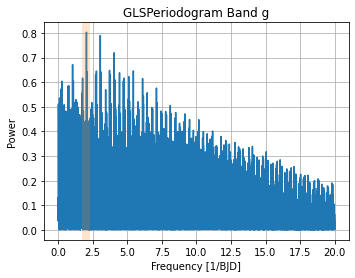

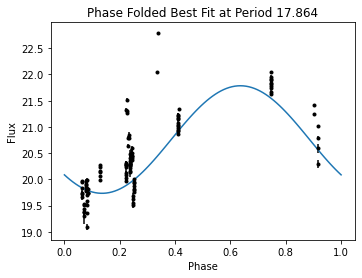

FITTING BEST PEFRIOD TO BAND r
PERIOD:  17.86422930262837


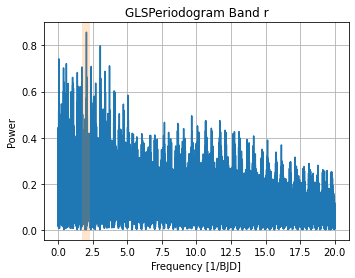

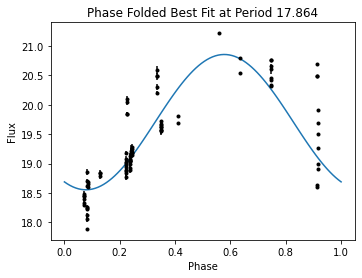

FITTING BEST PEFRIOD TO BAND i
PERIOD:  17.86422930262837


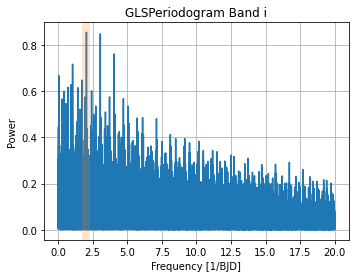

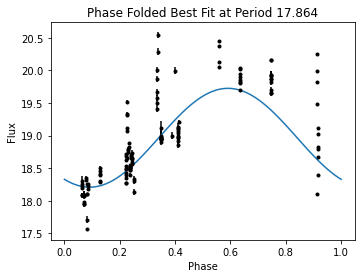

FITTING BEST PEFRIOD TO BAND z
PERIOD:  17.86422930262837


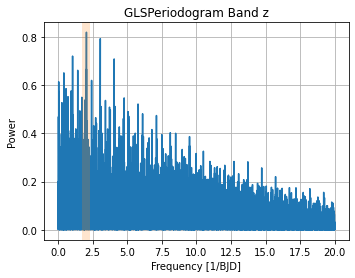

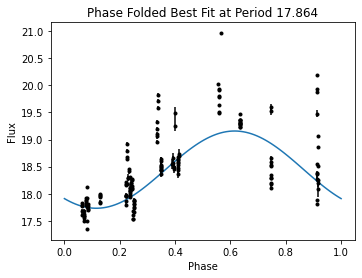

DC21nqox
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:36:40 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:36:40 kbls:1143] minimum epoch is actually an array:
array([59699.40939935])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:36:40 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:37:00 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:37:00 kbls:1143] minimum epoch is actually an array:
array([59333.3518785])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:37:00 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:37:17 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:37:17 kbls:1143] minimum epoch is actually an array:
array([59367.30694054])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:37:17 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:37:36 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:37:36 kbls:1143] minimum epoch is actually an array:
array([59367.28442749])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:37:36 kbls:1120] multiple possible times-of-center transits found for period 0.8928405, picking the first one from: array([59474.00373005, 59764.17693469])


COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[10.021993510069116, 2.3207617919748262, 2.318517408857243, 2.298186610866774, 2.2892647568994184, 2.2738170122479717, 1.7851049008446036, 1.7770357716117897, 1.7690392631569747, 1.1145388227730508, 1.1145388227730508, 0.9997479151477655, 0.6986117798103267, 0.6407318929048794, 0.5330107896572744, 0.5270558473146716, 0.475618747834844, 0.45453862657578115, 0.41090881291087694, 0.39264576964058395, 0.36119975250277164, 0.3554304535483501, 0.34670580917759986, 10.329202891220017, 0.3122388119344978, 0.2910129056686424, 10.284167756260112, 0.26204532751568843, 0.24996548609379024, 0.2361986010166606, 0.22528015119299216, 10.284167756260112, 0.19938228860621648, 0.18713875489929657, 0.17602244916324394, 440.1694127644153, 0.14279651139070249, 0.13612160490926875, 0.12468121758468066, 9.73253011638071, 8.040543726680214, 2.318517408857243, 12.262316290064074, 1.1415074721918237, 0.9997479151477655, 0.893011582324919, 0.812425938734231

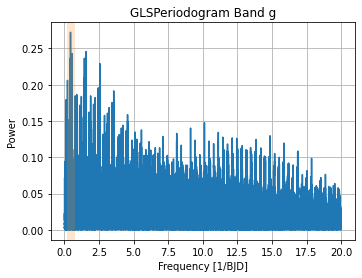

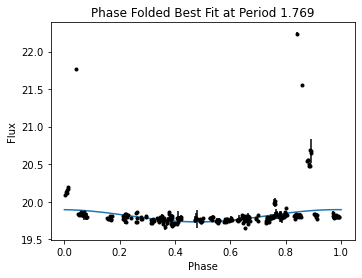

FITTING BEST PEFRIOD TO BAND r
PERIOD:  1.7690392631569747


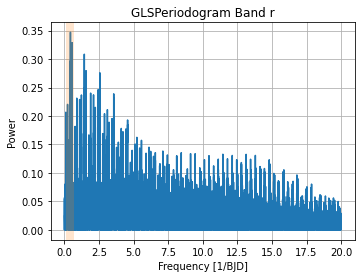

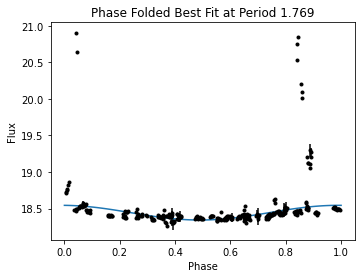

FITTING BEST PEFRIOD TO BAND i
PERIOD:  1.7690392631569747


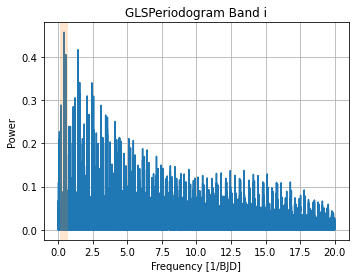

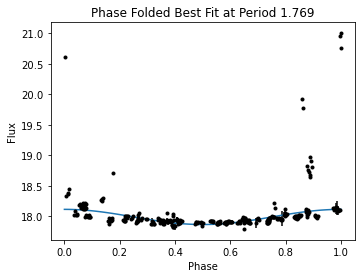

FITTING BEST PEFRIOD TO BAND z
PERIOD:  1.7690392631569747


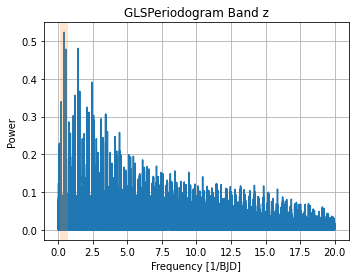

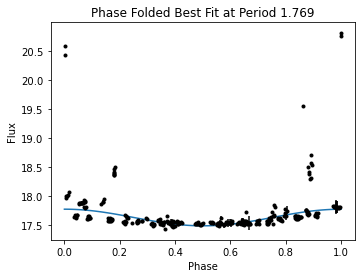

DC21nqpq
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21nrcb
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:41:30 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:41:30 kbls:1143] minimum epoch is actually an array:
array([59358.33273088])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:41:30 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:42:04 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:42:04 kbls:1143] minimum epoch is actually an array:
array([59720.37663293])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:42:04 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:42:25 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[E 220713 10:42:27 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:42:27 kbls:1143] minimum epoch is actually an array:
array([59333.35055003])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:42:27 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perl

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:42:45 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:42:45 kbls:1143] minimum epoch is actually an array:
array([59755.22964433])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:42:45 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.5146680474281311, 1.0246951580047607, 0.8809796571731567, 0.6868131756782532]
STARTING FAP CALCULATION FOR PERIOD: 0.5146680474281311
STARTING FAP CALCULATION FOR PERIOD: 1.0246951580047607
STARTING FAP CALCULATION FOR PERIOD: 0.8809796571731567
STARTING FAP CALCULATION FOR PERIOD: 0.6868131756782532
FITTING BEST PEFRIOD TO BAND g
PERIOD:  0.5146680474281311


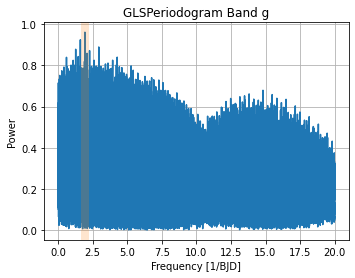

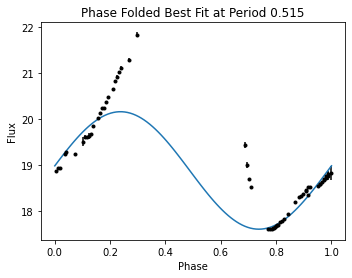

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.5146680474281311


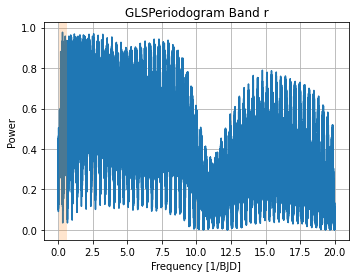

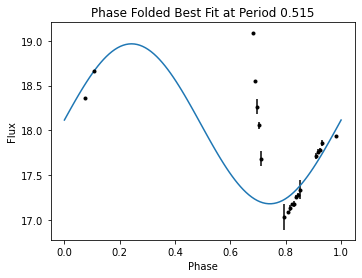

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.5146680474281311


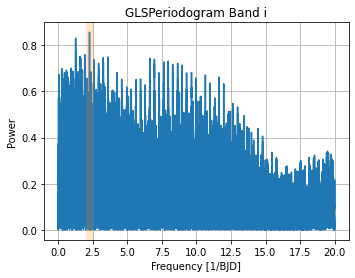

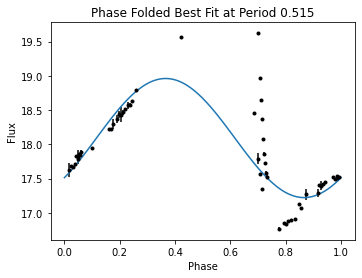

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.5146680474281311


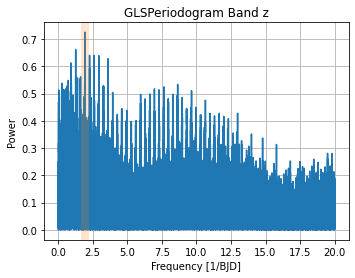

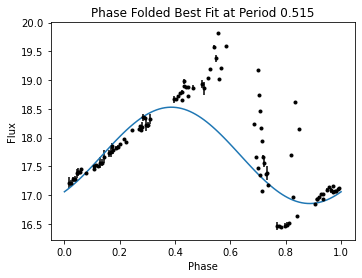

DC21nrdx
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21nthz
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:43:10 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:43:10 kbls:1143] minimum epoch is actually an array:
array([59714.30352043])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:43:10 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:43:28 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:43:28 kbls:1143] minimum epoch is actually an array:
array([59714.31387105])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:43:28 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:43:48 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:43:48 kbls:1143] minimum epoch is actually an array:
array([59333.35249747])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:43:48 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:44:07 kbls:1120] multiple possible times-of-center transits found for period 0.9927258, picking the first one from: array([59304.37812479, 59708.41786605])
[E 220713 10:44:07 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py", line 800, in curve_fit
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py", line 827, in least_squares
    raise ValueError("Residuals are not finite in the initial point.")
ValueError: Residuals are not finite in the init

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[3.1406733469491797, 3.1395770218746097, 3.111797667199267, 3.1395770218746097, 3.0800033872008656, 3.062125238548207, 3.0576880841663843, 3.0356938137524963, 2.9885136010750863, 2.9757599460754074, 2.9620780754309615, 2.9590682191027415, 412.9321141553591, 2.9100979777639493, 2.8901688067243607, 2.8862156830533214, 1.5306963981513713, 1.5256496884804605, 1.5190599315871554, 1.5256496884804605, 1.4993646605254187, 1.4879955334666592, 1.4796483771560391, 1.4693452093533785, 1.0154564297469872, 1.0076554784417768, 0.9995411963887905, 130.98218592222804, 0.755210585730322, 0.7474527917059969, 0.6030509104412711, 0.5987728736729956, 0.5987728736729956, 0.4984849167718681, 0.4302266468856252, 0.42879380788102667, 0.37546266949415114, 0.33387733905540434, 0.37546266949415114, 0.27276519051413173, 0.23008572833930013, 0.21376942677566346, 0.2996036572180638, 0.19942534652508276, 0.1868686658337104, 0.17578492130749188, 0.165720828072726

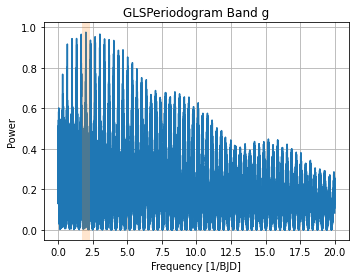

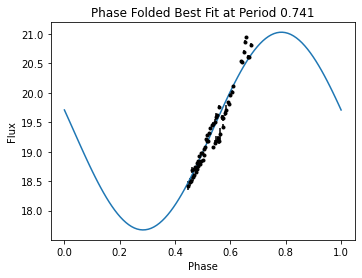

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.7413997650146484


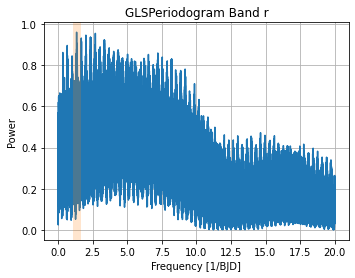

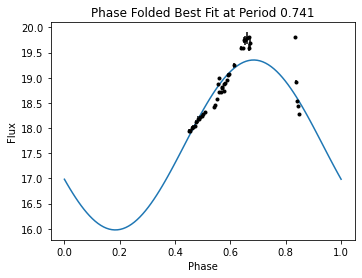

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.7413997650146484


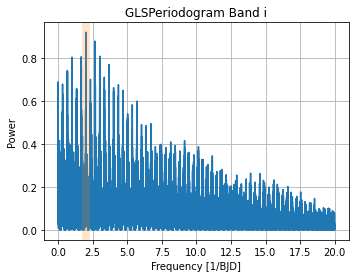

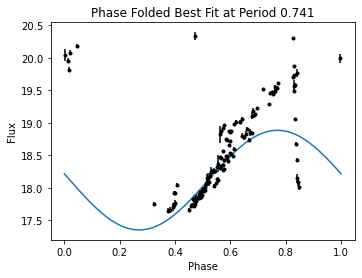

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.7413997650146484


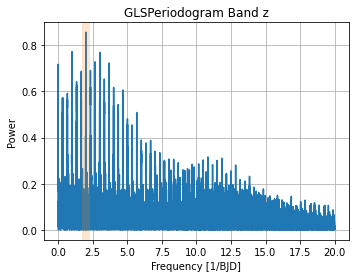

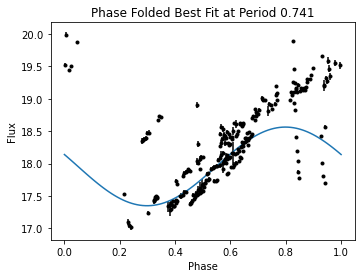

DC21nvfu
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21nvlp
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21oadi
ANALYZING GLS DATA FOR BAND g
FINISHED AN

[E 220713 10:45:44 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:45:44 kbls:1143] minimum epoch is actually an array:
array([59474.02020215])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:45:44 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[E 220713 10:45:45 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perl

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:46:00 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[E 220713 10:46:02 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:46:02 kbls:1143] minimum epoch is actually an array:
array([59361.25478564])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:46:02 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astr

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:46:19 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:46:19 kbls:1143] minimum epoch is actually an array:
array([59474.0184222])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:46:19 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-ana

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:46:36 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:46:36 kbls:1143] minimum epoch is actually an array:
array([59474.01910002])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:46:36 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.35412094801454436, 0.2613387952922616, 0.33182734226873883, 0.25130004954860485, 0.15037294333646312, 0.3541201949119568, 1.0765421390533447]
STARTING FAP CALCULATION FOR PERIOD: 0.35412094801454436
STARTING FAP CALCULATION FOR PERIOD: 0.2613387952922616
STARTING FAP CALCULATION FOR PERIOD: 0.33182734226873883
STARTING FAP CALCULATION FOR PERIOD: 0.25130004954860485
STARTING FAP CALCULATION FOR PERIOD: 0.15037294333646312
STARTING FAP CALCULATION FOR PERIOD: 0.3541201949119568
STARTING FAP CALCULATION FOR PERIOD: 1.0765421390533447
FITTING BEST PEFRIOD TO BAND g
PERIOD:  0.35412094801454436


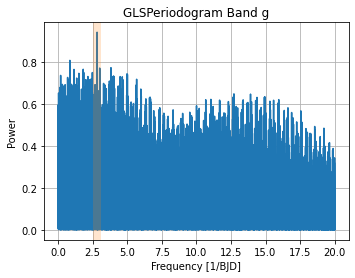

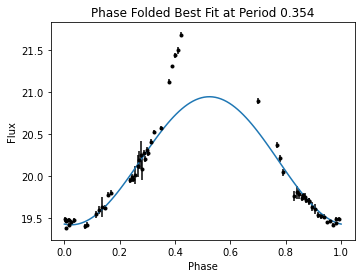

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.35412094801454436


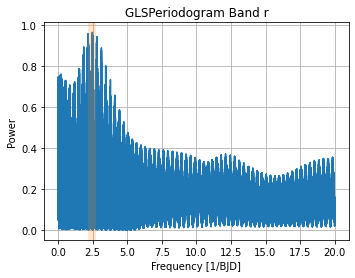

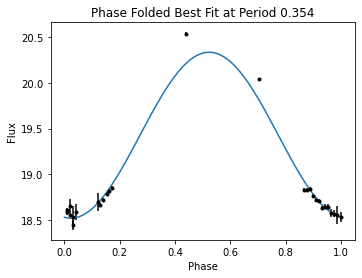

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.35412094801454436


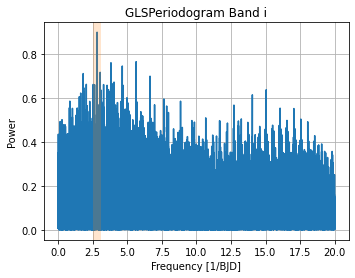

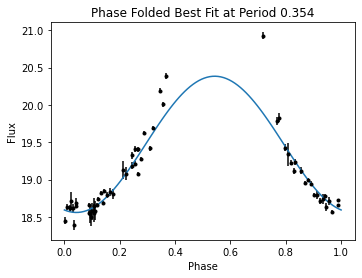

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.35412094801454436


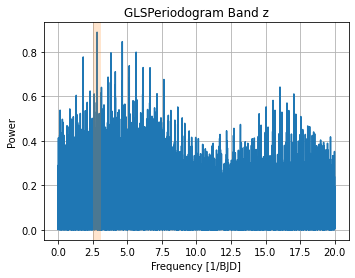

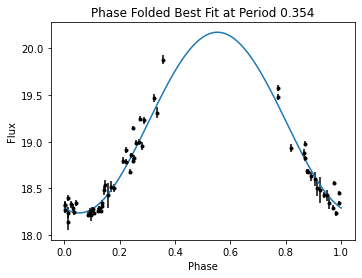

DC21oajl
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:46:59 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:46:59 kbls:1143] minimum epoch is actually an array:
array([59358.32898108])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:46:59 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:47:23 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:47:23 kbls:1143] minimum epoch is actually an array:
array([59364.37656422])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:47:23 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:47:49 kbls:1120] multiple possible times-of-center transits found for period 0.1559814, picking the first one from: array([59361.28684333, 59358.32341742])
[E 220713 10:47:49 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:47:49 kbls:1143] minimum epoch is actually an array:
array([59746.22792422])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:47:49 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perl

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:48:07 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:48:07 kbls:1143] minimum epoch is actually an array:
array([59361.28377315])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:48:07 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[2.0723136507870126, 0.877802383350334, 0.6735357889444575, 0.5539383564201993, 0.46503155614105957, 0.46503155614105957, 0.3238573382562697, 0.6733553409576416, 0.5743825435638428, 0.4093327820301056]
STARTING FAP CALCULATION FOR PERIOD: 2.0723136507870126
STARTING FAP CALCULATION FOR PERIOD: 0.877802383350334
STARTING FAP CALCULATION FOR PERIOD: 0.6735357889444575
STARTING FAP CALCULATION FOR PERIOD: 0.5539383564201993
STARTING FAP CALCULATION FOR PERIOD: 0.46503155614105957
STARTING FAP CALCULATION FOR PERIOD: 0.46503155614105957
STARTING FAP CALCULATION FOR PERIOD: 0.3238573382562697
STARTING FAP CALCULATION FOR PERIOD: 0.6733553409576416
STARTING FAP CALCULATION FOR PERIOD: 0.5743825435638428
STARTING FAP CALCULATION FOR PERIOD: 0.4093327820301056
FITTING BEST PEFRIOD TO BAND g
PERIOD:  0.6733553409576416


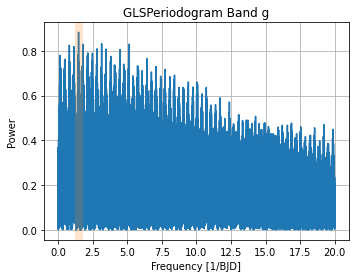

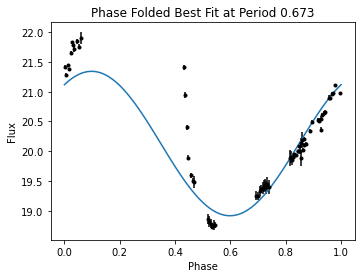

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.6733553409576416


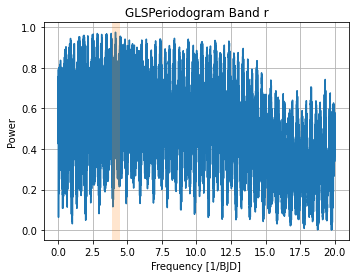

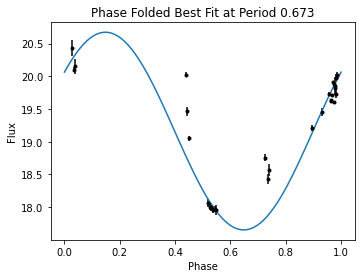

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.6733553409576416


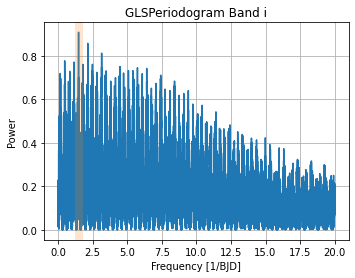

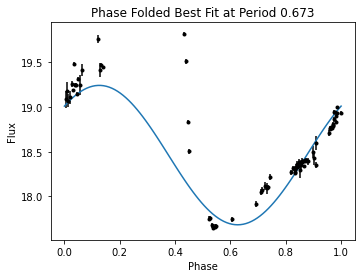

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.6733553409576416


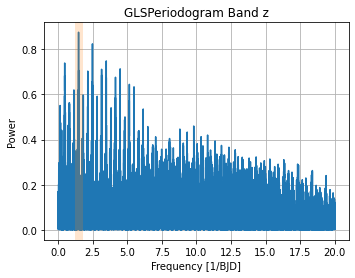

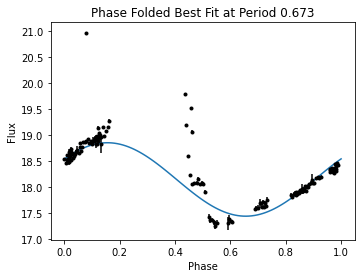

DC21ocgm
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21oevd
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC

[E 220713 10:48:36 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:48:36 kbls:1143] minimum epoch is actually an array:
array([59361.35077548])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:48:36 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:48:50 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[W 220713 10:48:51 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[E 220713 10:48:53 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:48:53 kbls:1143] minimum epoch is actually an array:
array([59361.35593222])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:48:53 kbls:411] more 

Sorry, no significant peaks in this periodogram
COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:49:10 kbls:1120] multiple possible times-of-center transits found for period 0.9913141, picking the first one from: array([59333.36653041, 59333.3684577 ])
[E 220713 10:49:10 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py", line 800, in curve_fit
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py", line 827, in least_squares
    raise ValueError("Residuals are not finite in the initial point.")
ValueError: Residuals are not finite in the init

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:49:26 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:49:26 kbls:1143] minimum epoch is actually an array:
array([59708.4253042])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:49:26 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.9844440522404867, 0.743122652602952, 0.5937314800371647, 0.5937314800371647, 0.4954189324711158, 0.4225164530564367, 0.37190031552335623, 0.3306777683740184, 0.27024809558912133, 0.7401924729347229, 0.5930846333503723]
STARTING FAP CALCULATION FOR PERIOD: 0.9844440522404867
STARTING FAP CALCULATION FOR PERIOD: 0.743122652602952
STARTING FAP CALCULATION FOR PERIOD: 0.5937314800371647
STARTING FAP CALCULATION FOR PERIOD: 0.5937314800371647
STARTING FAP CALCULATION FOR PERIOD: 0.4954189324711158
STARTING FAP CALCULATION FOR PERIOD: 0.4225164530564367
STARTING FAP CALCULATION FOR PERIOD: 0.37190031552335623
STARTING FAP CALCULATION FOR PERIOD: 0.3306777683740184
STARTING FAP CALCULATION FOR PERIOD: 0.27024809558912133
STARTING FAP CALCULATION FOR PERIOD: 0.7401924729347229
STARTING FAP CALCULATION FOR PERIOD: 0.5930846333503723
FITTING BEST PEFRIOD TO BAND g
PERIOD:  0.743122652602952


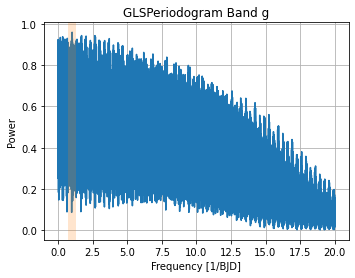

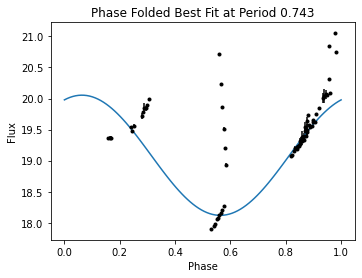

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.743122652602952


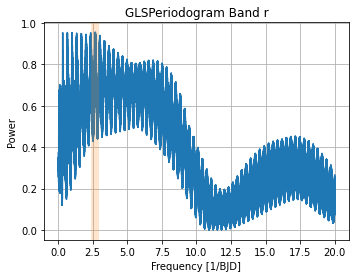

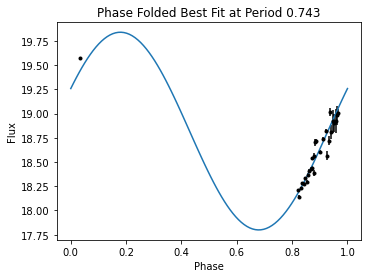

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.743122652602952


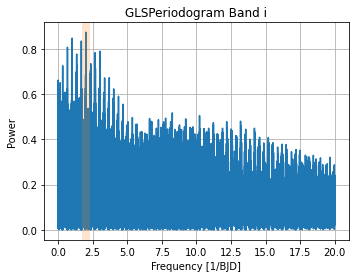

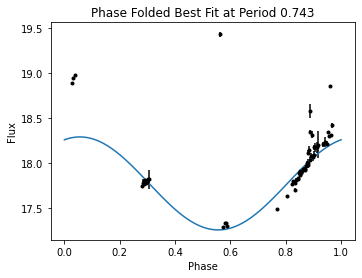

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.743122652602952


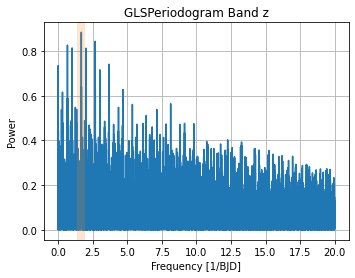

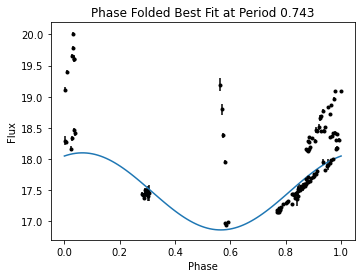

DC21ogcb
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21okqg
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:49:54 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:49:54 kbls:1143] minimum epoch is actually an array:
array([59331.3475867])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:49:54 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-ana

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:50:13 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:50:13 kbls:1143] minimum epoch is actually an array:
array([59477.00716521])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:50:13 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:50:31 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:50:31 kbls:1143] minimum epoch is actually an array:
array([59510.00417492])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:50:31 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:50:49 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:50:49 kbls:1143] minimum epoch is actually an array:
array([59352.31114728])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:50:49 kbls:1120] multiple possible times-of-center transits found for period 0.2073452, picking the first one from: array([59510.00484514, 59361.33850102])
[E 220713 10:50:49 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perl

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.35862630767342585, 0.2682478342068857, 0.22797584912463972, 0.2117247536306256, 0.17465653712682652, 0.15405964335803204, 0.6730373088786843, 0.36690699758004647, 0.1822105140905301, 0.1699206673730546, 0.5235328078269958, 0.35497498512268066, 0.26378265023231506]
STARTING FAP CALCULATION FOR PERIOD: 0.35862630767342585
STARTING FAP CALCULATION FOR PERIOD: 0.2682478342068857
STARTING FAP CALCULATION FOR PERIOD: 0.22797584912463972
STARTING FAP CALCULATION FOR PERIOD: 0.2117247536306256
STARTING FAP CALCULATION FOR PERIOD: 0.17465653712682652
STARTING FAP CALCULATION FOR PERIOD: 0.15405964335803204
STARTING FAP CALCULATION FOR PERIOD: 0.6730373088786843
STARTING FAP CALCULATION FOR PERIOD: 0.36690699758004647
STARTING FAP CALCULATION FOR PERIOD: 0.1822105140905301
STARTING FAP CALCULATION FOR PERIOD: 0.1699206673730546
STARTING FAP CALCULATION FOR PERIOD: 0.5235328078269958
STARTING FAP CALCULATION FOR PERIOD: 0.354974985122680

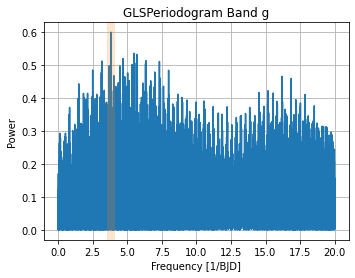

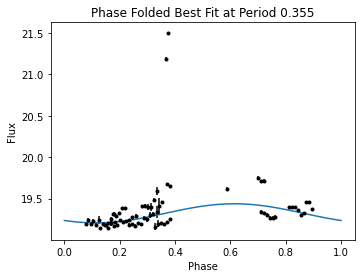

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.35497498512268066


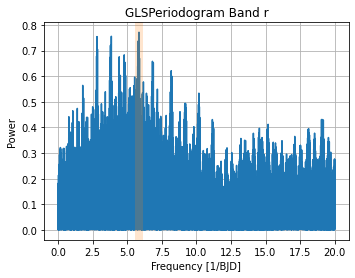

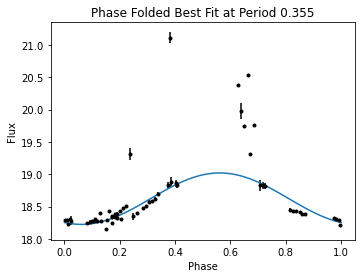

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.35497498512268066


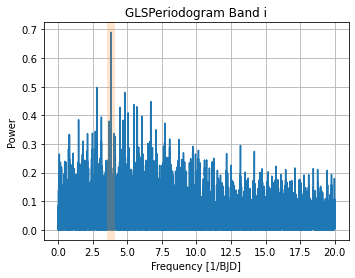

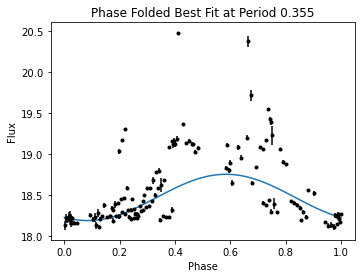

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.35497498512268066


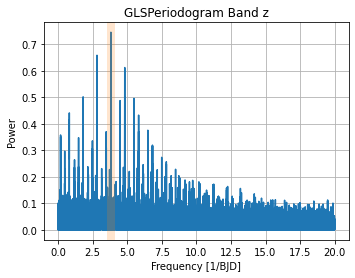

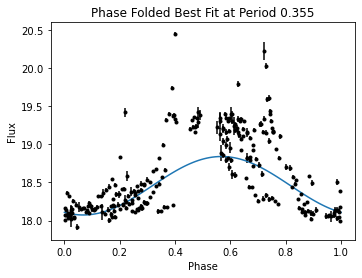

DC21otlr
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21ozgc
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21pazg
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA F

[E 220713 10:51:35 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:51:35 kbls:1143] minimum epoch is actually an array:
array([59714.31241377])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:51:35 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:51:52 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:51:52 kbls:1143] minimum epoch is actually an array:
array([59304.38808794])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:51:52 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:52:13 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:52:13 kbls:1143] minimum epoch is actually an array:
array([59333.35055003])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:52:13 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:52:31 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:52:31 kbls:1143] minimum epoch is actually an array:
array([59361.28753214])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:52:31 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.2161780959855887, 0.2622846429137169, 0.2409823736395525, 0.2232668041675458, 0.1941895984817134, 0.18244664810145886, 0.17783579655153978, 0.16254591810073638, 0.15423635492731075, 0.1436756937913783, 0.13987076174252988, 0.12558679103029774, 0.11590046849786571, 0.1941895984817134, 0.09711637402193188, 0.08850006970252529, 0.07913927205198436, 0.06922108834313545, 0.10383030027151108, 0.13113033771514893, 0.1255839616060257, 0.26226067543029785, 0.09403976052999496]
STARTING FAP CALCULATION FOR PERIOD: 0.2161780959855887
STARTING FAP CALCULATION FOR PERIOD: 0.2622846429137169
STARTING FAP CALCULATION FOR PERIOD: 0.2409823736395525
STARTING FAP CALCULATION FOR PERIOD: 0.2232668041675458
STARTING FAP CALCULATION FOR PERIOD: 0.1941895984817134
STARTING FAP CALCULATION FOR PERIOD: 0.18244664810145886
STARTING FAP CALCULATION FOR PERIOD: 0.17783579655153978
STARTING FAP CALCULATION FOR PERIOD: 0.16254591810073638
STARTING FAP CAL

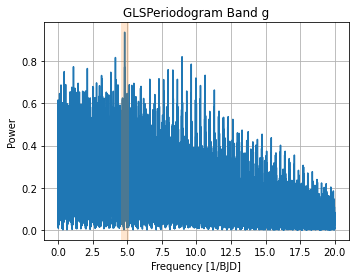

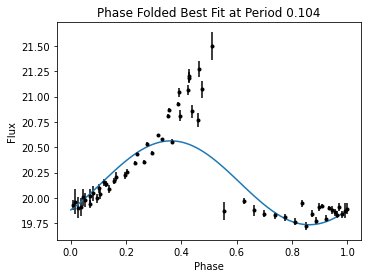

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.10383030027151108


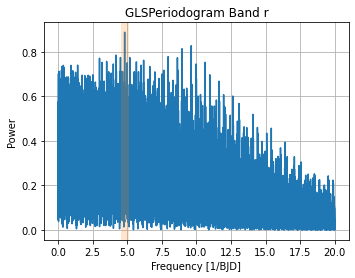

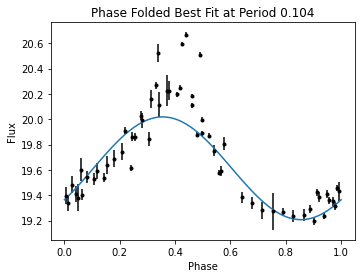

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.10383030027151108


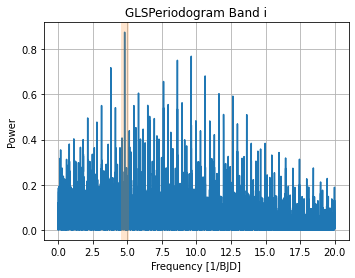

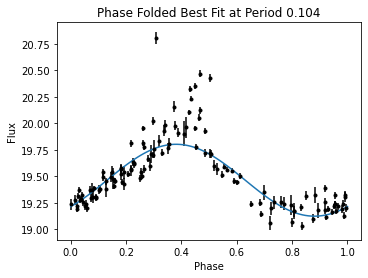

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.10383030027151108


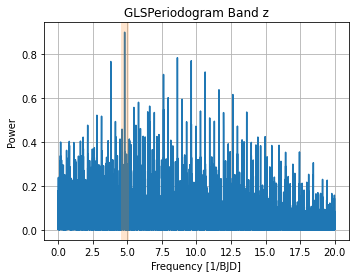

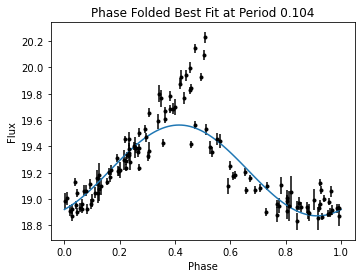

DC21pcjg
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21peva
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21pitp
ANALYZING GLS DATA FOR BAND g
FINISHED AN

[E 220713 10:53:21 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:53:21 kbls:1143] minimum epoch is actually an array:
array([59764.17762005])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:53:21 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:53:40 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:53:40 kbls:1143] minimum epoch is actually an array:
array([59358.29549865])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:53:40 kbls:1120] multiple possible times-of-center transits found for period 0.3569319, picking the first one from: array([59364.28320447, 59340.36931223])
[W 220713 10:53:40 kbls:1120] multiple possible times-of-center transits found for period 3.5488684, picking the first one from: array([59714.39201148, 59313.37108446])
[E 220713 10:53:40 kbls:1129] coul

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:53:58 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:53:58 kbls:1143] minimum epoch is actually an array:
array([59358.31968871])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:53:58 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:54:15 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:54:15 kbls:1143] minimum epoch is actually an array:
array([59358.32409521])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:54:15 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[2.4638245285721356, 2.4586881299254286, 2.433324062242519, 1.6965146453313873, 1.684399788132373, 0.7110367533935403, 0.41517603506120804, 0.2931467604889441, 0.23007037304247469, 0.18712390893113315, 0.16439260017091664, 0.13477605008882038, 3.8582320959075562, 2.4484793137635124, 2.4207803783777138, 0.792233718662374, 0.5735793350633136, 0.3641552199497778, 0.27797997492365034, 0.26675732893827275, 0.2104656462837287, 2.461841583251953, 4.923683166503906, 2.4319064617156982, 1.6832183599472046]
STARTING FAP CALCULATION FOR PERIOD: 2.4638245285721356
STARTING FAP CALCULATION FOR PERIOD: 2.4586881299254286
STARTING FAP CALCULATION FOR PERIOD: 2.433324062242519
STARTING FAP CALCULATION FOR PERIOD: 1.6965146453313873
STARTING FAP CALCULATION FOR PERIOD: 1.684399788132373
STARTING FAP CALCULATION FOR PERIOD: 0.7110367533935403
STARTING FAP CALCULATION FOR PERIOD: 0.41517603506120804
STARTING FAP CALCULATION FOR PERIOD: 0.2931467604

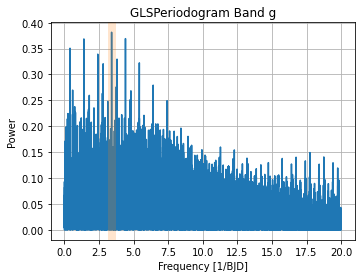

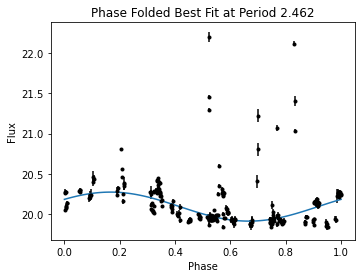

FITTING BEST PEFRIOD TO BAND r
PERIOD:  2.461841583251953


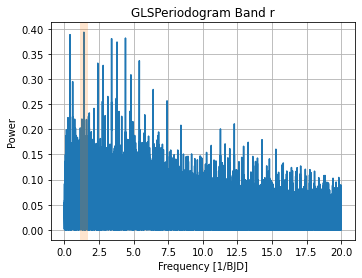

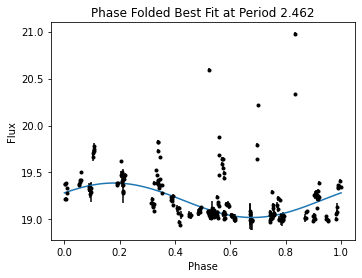

FITTING BEST PEFRIOD TO BAND i
PERIOD:  2.461841583251953


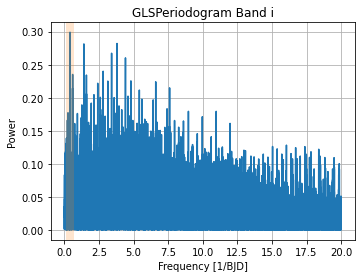

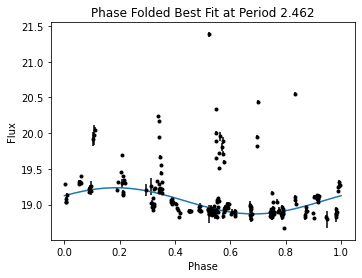

FITTING BEST PEFRIOD TO BAND z
PERIOD:  2.461841583251953


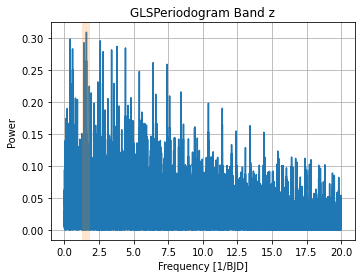

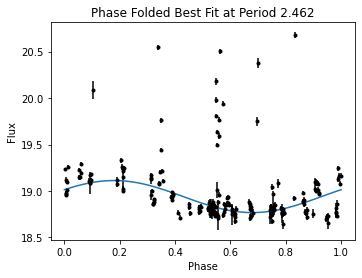

DC21psdt
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
skipping candidate
[]
DC21pwmx
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:55:45 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:55:45 kbls:1143] minimum epoch is actually an array:
array([59367.3198358])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:55:45 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[E 220713 10:55:47 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlm

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:56:05 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:56:05 kbls:1143] minimum epoch is actually an array:
array([59504.00782202])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:56:05 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:56:24 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:56:24 kbls:1143] minimum epoch is actually an array:
array([59319.42446337])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:56:24 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:56:40 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[E 220713 10:56:42 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:56:42 kbls:1143] minimum epoch is actually an array:
array([59329.38366174])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:56:42 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perl

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.38999735729323215, 0.19092792441509712, 0.1603097136229781, 0.12134795535848865, 3.2606711669107855, 3.2380065009939467, 1.4482063825700817, 0.7638377016331572, 0.5914259410729698, 0.42338724341968514, 0.37128493189019457, 0.314401876785652, 0.3986753442358919, 0.28480054386988446, 0.23905510693085602, 0.38166484236717224, 0.19090528786182404]
STARTING FAP CALCULATION FOR PERIOD: 0.38999735729323215
STARTING FAP CALCULATION FOR PERIOD: 0.19092792441509712
STARTING FAP CALCULATION FOR PERIOD: 0.1603097136229781
STARTING FAP CALCULATION FOR PERIOD: 0.12134795535848865
STARTING FAP CALCULATION FOR PERIOD: 3.2606711669107855
STARTING FAP CALCULATION FOR PERIOD: 3.2380065009939467
STARTING FAP CALCULATION FOR PERIOD: 1.4482063825700817
STARTING FAP CALCULATION FOR PERIOD: 0.7638377016331572
STARTING FAP CALCULATION FOR PERIOD: 0.5914259410729698
STARTING FAP CALCULATION FOR PERIOD: 0.42338724341968514
STARTING FAP CALCULATION FOR P

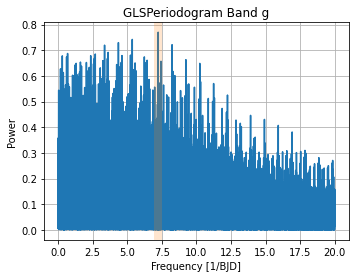

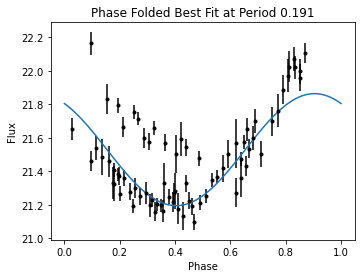

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.19090528786182404


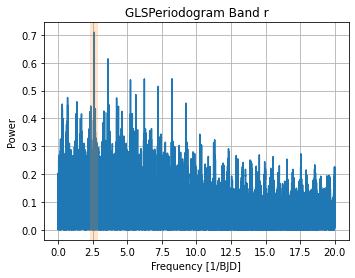

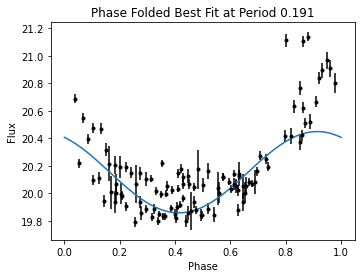

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.19090528786182404


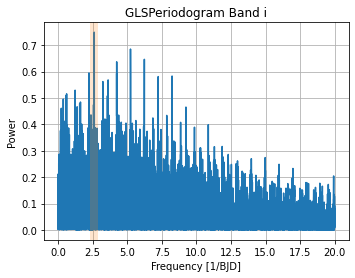

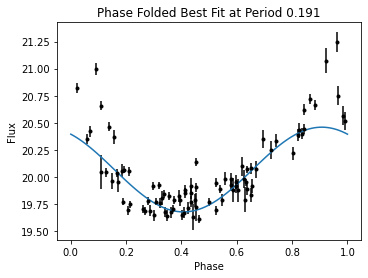

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.19090528786182404


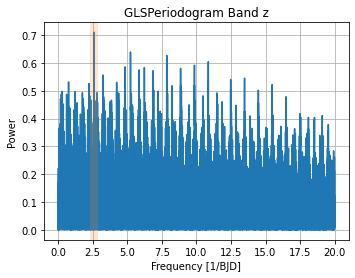

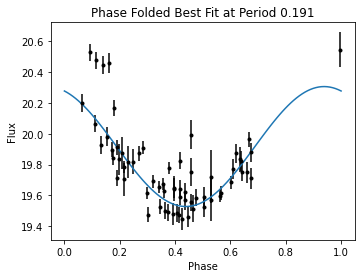

DC21qexc
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[W 220713 10:57:18 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[W 220713 10:57:20 kbls:1120] multiple possible times-of-center transits found for period 0.0018851, picking the first one from: array([59356.29260703, 59313.38119811])
[W 220713 10:57:20 kbls:1120] multiple possible times-of-center transits found for period 0.1594053, picking the first one from: array([59352.30025847, 59310.37712498])


COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:57:39 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:57:39 kbls:1143] minimum epoch is actually an array:
array([59322.38170803])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:57:39 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:57:58 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:57:58 kbls:1143] minimum epoch is actually an array:
array([59755.23641354])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:57:58 kbls:411] more than 5.0e5 frequencies to go through; this will take a while. you might want to use the periodbase.bls_parallel_pfind function instead
[E 220713 10:58:01 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perl

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:58:19 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:58:19 kbls:1143] minimum epoch is actually an array:
array([59364.28848574])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 10:58:20 kbls:1120] multiple possible times-of-center transits found for period 0.1896403, picking the first one from: array([59474.03064677, 59764.18065133])


COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.23430048949046534, 0.15946444262613993, 0.1374846268823522, 0.12079263829632725, 0.18973267194460172, 0.09484462542873338, 0.44149007702787296, 0.18973267194460172, 0.22062752450759027, 0.08660925605970055, 0.6120700836181641, 0.27487629652023315, 0.13743625581264496, 0.1896417737007141]
STARTING FAP CALCULATION FOR PERIOD: 0.23430048949046534
STARTING FAP CALCULATION FOR PERIOD: 0.15946444262613993
STARTING FAP CALCULATION FOR PERIOD: 0.1374846268823522
STARTING FAP CALCULATION FOR PERIOD: 0.12079263829632725
STARTING FAP CALCULATION FOR PERIOD: 0.18973267194460172
STARTING FAP CALCULATION FOR PERIOD: 0.09484462542873338
STARTING FAP CALCULATION FOR PERIOD: 0.44149007702787296
STARTING FAP CALCULATION FOR PERIOD: 0.18973267194460172
STARTING FAP CALCULATION FOR PERIOD: 0.22062752450759027
STARTING FAP CALCULATION FOR PERIOD: 0.08660925605970055
STARTING FAP CALCULATION FOR PERIOD: 0.6120700836181641
STARTING FAP CALCULATION F

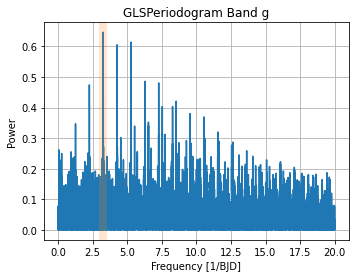

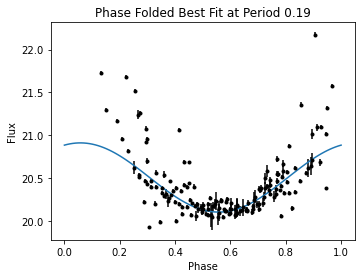

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.1896417737007141


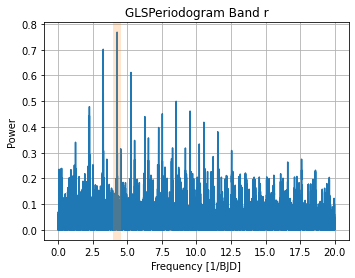

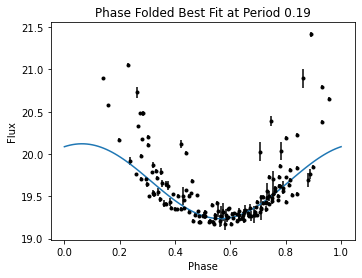

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.1896417737007141


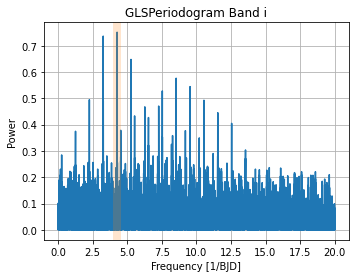

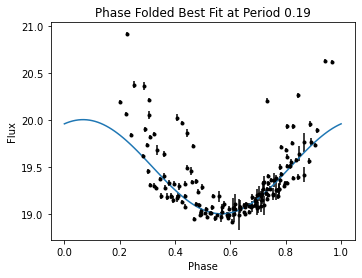

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.1896417737007141


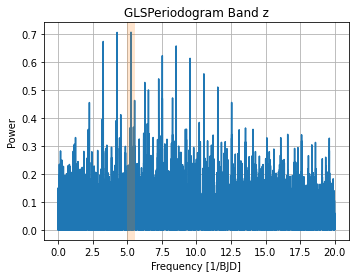

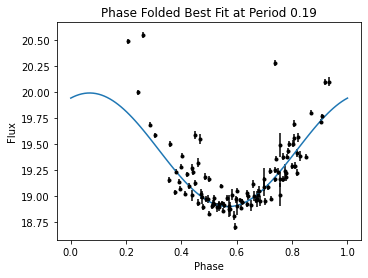

DC21qkde
ANALYZING GLS DATA FOR BAND g
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:59:03 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:59:03 kbls:1143] minimum epoch is actually an array:
array([59693.38999279])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:59:03 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 10:59:42 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 10:59:42 kbls:1143] minimum epoch is actually an array:
array([59714.3012557])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 10:59:42 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:00:10 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py", line 800, in curve_fit
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py", line 827, in least_squares
    raise ValueError("Residuals are not finite in the initial point.")
ValueError: Residuals are not finite in the initial point.
[E 220713 11:00:10 transits:498] trapezoid-fit: least-squared fit to the light curve failed!
[E 220713 11:00:10 kbls:1129] could not determine the center time

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[W 220713 11:00:29 kbls:1120] multiple possible times-of-center transits found for period 0.4748344, picking the first one from: array([59711.36064319, 59761.21854599])
[E 220713 11:00:29 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:00:29 kbls:1143] minimum epoch is actually an array:
array([59358.33205664])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:00:29 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astr

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[9.937050132976658, 1.1123800958094148, 0.9134145027337096, 0.6488393854392293, 0.5326496952898262, 0.4749243703718838, 0.3217200067122966, 0.47485634684562683, 0.32166752219200134, 0.31161385774612427]
STARTING FAP CALCULATION FOR PERIOD: 9.937050132976658
STARTING FAP CALCULATION FOR PERIOD: 1.1123800958094148
STARTING FAP CALCULATION FOR PERIOD: 0.9134145027337096
STARTING FAP CALCULATION FOR PERIOD: 0.6488393854392293
STARTING FAP CALCULATION FOR PERIOD: 0.5326496952898262
STARTING FAP CALCULATION FOR PERIOD: 0.4749243703718838
STARTING FAP CALCULATION FOR PERIOD: 0.3217200067122966
STARTING FAP CALCULATION FOR PERIOD: 0.47485634684562683
STARTING FAP CALCULATION FOR PERIOD: 0.32166752219200134
STARTING FAP CALCULATION FOR PERIOD: 0.31161385774612427
FITTING BEST PEFRIOD TO BAND g
PERIOD:  0.4749243703718838


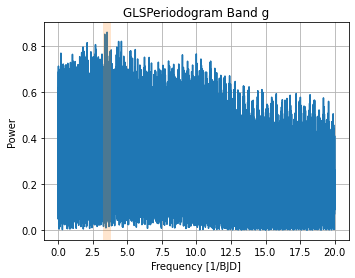

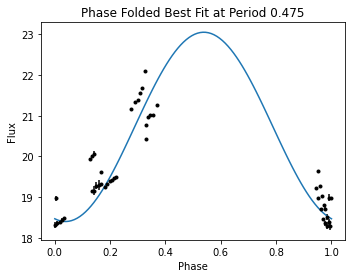

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.4749243703718838


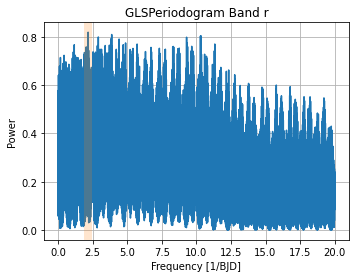

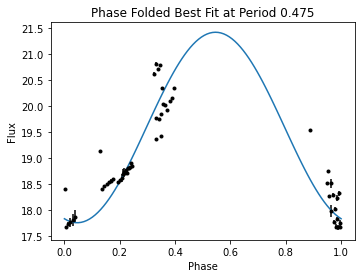

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.4749243703718838


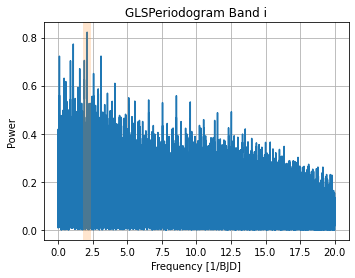

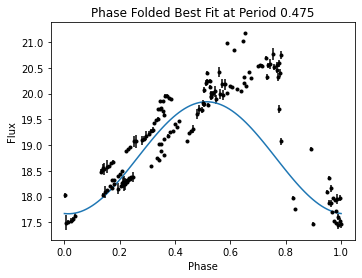

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.4749243703718838


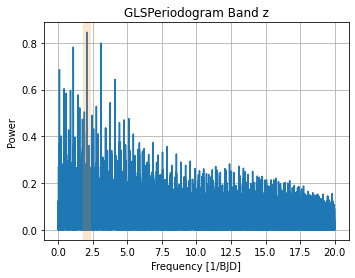

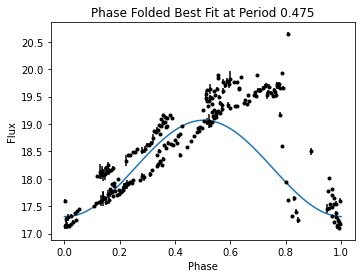

DC21rpoj
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:01:09 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:01:09 kbls:1143] minimum epoch is actually an array:
array([59714.38190692])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:01:09 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:01:27 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:01:27 kbls:1143] minimum epoch is actually an array:
array([59358.31504564])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:01:27 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:01:44 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:01:44 kbls:1143] minimum epoch is actually an array:
array([59364.38118902])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:01:45 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:02:03 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:02:03 kbls:1143] minimum epoch is actually an array:
array([59322.36784379])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:02:03 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.31208886653311035, 0.340505988380497, 0.26473641293368927, 0.22365537111709827, 0.2561658872701115, 0.18270499459284503, 0.16285526825886495, 0.1544194021646644, 0.13374831475070265, 0.11793432230368753, 0.1544043868780136, 0.13370771706104279]
STARTING FAP CALCULATION FOR PERIOD: 0.31208886653311035
STARTING FAP CALCULATION FOR PERIOD: 0.340505988380497
STARTING FAP CALCULATION FOR PERIOD: 0.26473641293368927
STARTING FAP CALCULATION FOR PERIOD: 0.22365537111709827
STARTING FAP CALCULATION FOR PERIOD: 0.2561658872701115
STARTING FAP CALCULATION FOR PERIOD: 0.18270499459284503
STARTING FAP CALCULATION FOR PERIOD: 0.16285526825886495
STARTING FAP CALCULATION FOR PERIOD: 0.1544194021646644
STARTING FAP CALCULATION FOR PERIOD: 0.13374831475070265
STARTING FAP CALCULATION FOR PERIOD: 0.11793432230368753
STARTING FAP CALCULATION FOR PERIOD: 0.1544043868780136
STARTING FAP CALCULATION FOR PERIOD: 0.13370771706104279
FITTING BEST PEF

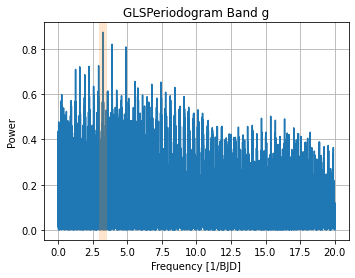

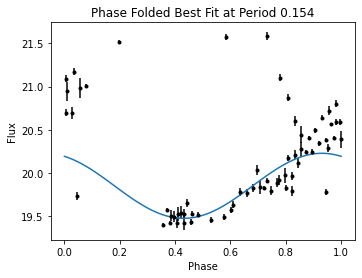

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.1544194021646644


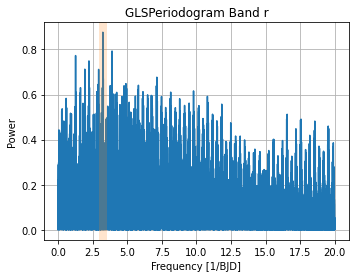

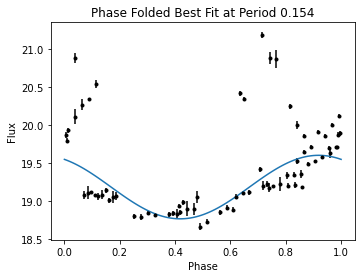

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.1544194021646644


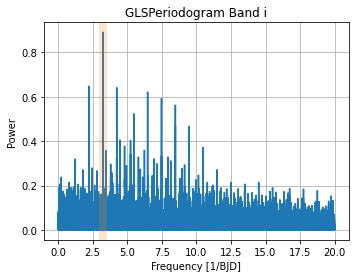

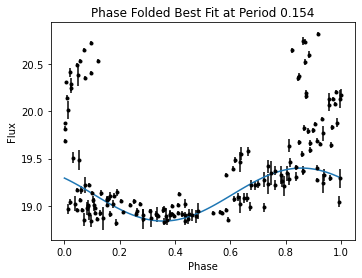

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.1544194021646644


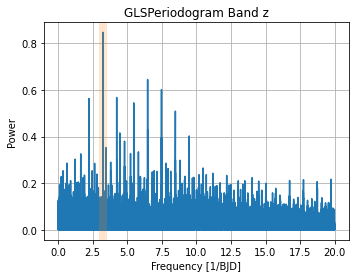

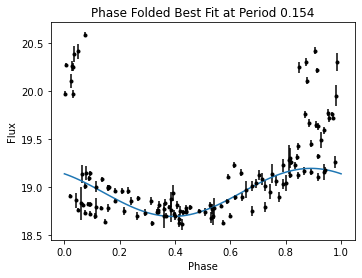

DC21saaw
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[W 220713 11:02:41 kbls:1120] multiple possible times-of-center transits found for period 0.6126561, picking the first one from: array([59331.33604215, 59304.37924296])
[E 220713 11:02:41 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py", line 800, in curve_fit
    res = least_squares(func, p0, jac=jac, bounds=bounds, method=method,
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/optimize/_lsq/least_squares.py", line 827, in least_squares
    raise ValueError("Residuals are not finite in the initial point.")
ValueError: Residuals are not finite in the init

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:03:00 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:03:00 kbls:1143] minimum epoch is actually an array:
array([59333.35771837])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:03:00 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:03:20 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:03:20 kbls:1143] minimum epoch is actually an array:
array([59473.9993521])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:03:20 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[W 220713 11:03:39 kbls:1120] multiple possible times-of-center transits found for period 0.4482822, picking the first one from: array([59352.34184506, 59720.38192946])


COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.2805219911335166, 0.2206897646974383, 0.19243591470869986, 0.1796464545405768, 0.19243591470869986, 0.18985745098247847, 0.16954228458171944, 0.1456632843948001, 0.13953277652914386, 0.12768029147108295, 0.11767752671104562, 0.0983674685841663, 0.19108037650585175, 1.0319917440660473, 0.28052064776420593]
STARTING FAP CALCULATION FOR PERIOD: 0.2805219911335166
STARTING FAP CALCULATION FOR PERIOD: 0.2206897646974383
STARTING FAP CALCULATION FOR PERIOD: 0.19243591470869986
STARTING FAP CALCULATION FOR PERIOD: 0.1796464545405768
STARTING FAP CALCULATION FOR PERIOD: 0.19243591470869986
STARTING FAP CALCULATION FOR PERIOD: 0.18985745098247847
STARTING FAP CALCULATION FOR PERIOD: 0.16954228458171944
STARTING FAP CALCULATION FOR PERIOD: 0.1456632843948001
STARTING FAP CALCULATION FOR PERIOD: 0.13953277652914386
STARTING FAP CALCULATION FOR PERIOD: 0.12768029147108295
STARTING FAP CALCULATION FOR PERIOD: 0.11767752671104562
STARTING F

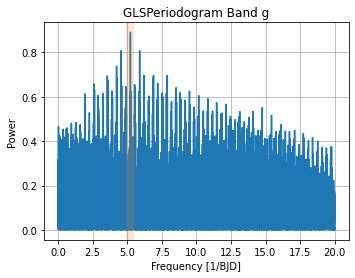

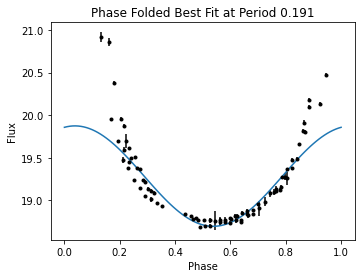

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.19108037650585175


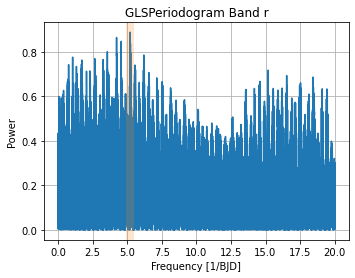

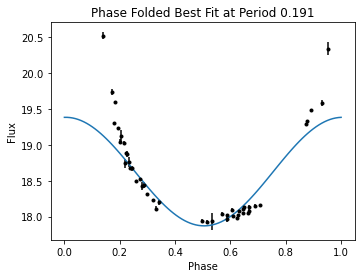

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.19108037650585175


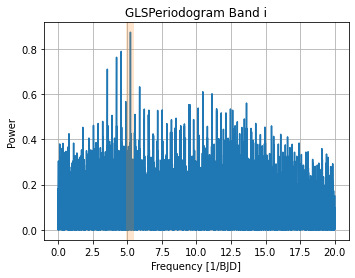

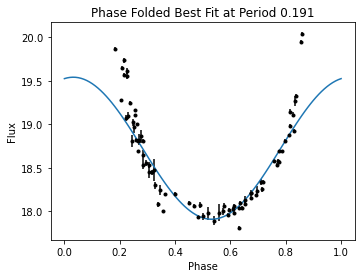

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.19108037650585175


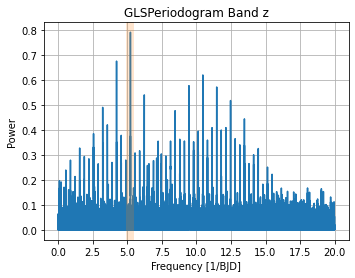

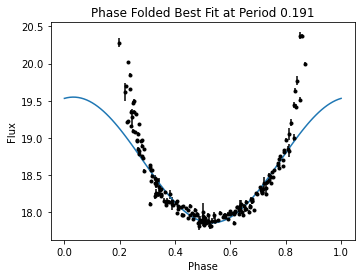

DC21sqxf
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
Sorry, no significant peaks in this periodogram
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:04:17 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:04:17 kbls:1143] minimum epoch is actually an array:
array([59329.38049035])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:04:17 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:04:34 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:04:34 kbls:1143] minimum epoch is actually an array:
array([59723.33118099])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:04:34 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:04:50 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:04:50 kbls:1143] minimum epoch is actually an array:
array([59361.33782298])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:04:50 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/lcfit/transits.py", line 419, in traptransit_fit_magseries
    finalparams, covmatrix = curve_fit(
  File "/global/common/software/nersc/pm-2022q2/sw/python/3.9-an

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:05:05 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:05:05 kbls:1143] minimum epoch is actually an array:
array([59337.43704718])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[W 220713 11:05:05 kbls:1120] multiple possible times-of-center transits found for period 0.4492479, picking the first one from: array([59705.35646378, 59364.37813978])
[E 220713 11:05:05 transits:429] curve_fit returned an exception
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astr

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[0.6908510241778698, 0.5382265130955994, 0.359106168327149, 0.26423257371661657, 0.22457175132604304, 0.21394007214645397, 0.29942683228055167, 0.18717544235512473, 0.17615655089034565, 0.1497662158144087, 0.138263875495599, 1.1313496828079224]
STARTING FAP CALCULATION FOR PERIOD: 0.6908510241778698
STARTING FAP CALCULATION FOR PERIOD: 0.5382265130955994
STARTING FAP CALCULATION FOR PERIOD: 0.359106168327149
STARTING FAP CALCULATION FOR PERIOD: 0.26423257371661657
STARTING FAP CALCULATION FOR PERIOD: 0.22457175132604304
STARTING FAP CALCULATION FOR PERIOD: 0.21394007214645397
STARTING FAP CALCULATION FOR PERIOD: 0.29942683228055167
STARTING FAP CALCULATION FOR PERIOD: 0.18717544235512473
STARTING FAP CALCULATION FOR PERIOD: 0.17615655089034565
STARTING FAP CALCULATION FOR PERIOD: 0.1497662158144087
STARTING FAP CALCULATION FOR PERIOD: 0.138263875495599
STARTING FAP CALCULATION FOR PERIOD: 1.1313496828079224
FITTING BEST PEFRIOD T

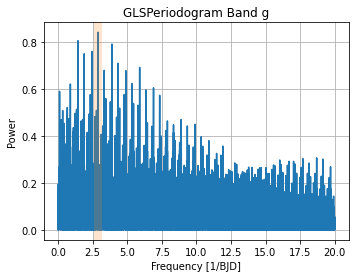

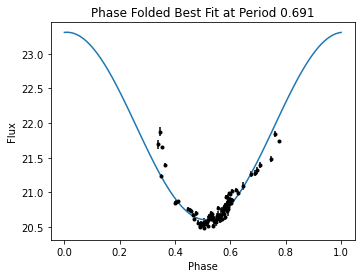

FITTING BEST PEFRIOD TO BAND r
PERIOD:  0.6908510241778698


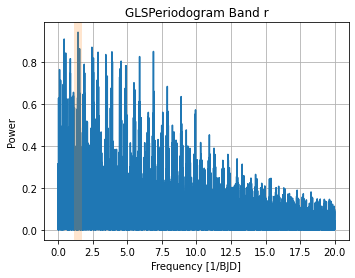

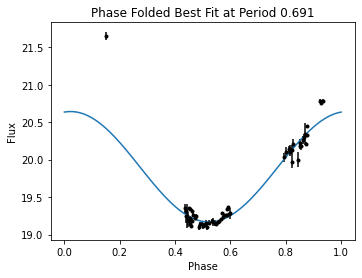

FITTING BEST PEFRIOD TO BAND i
PERIOD:  0.6908510241778698


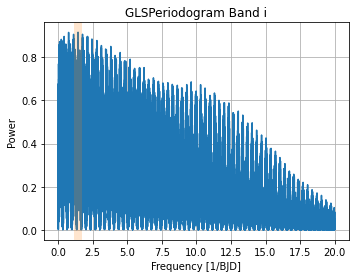

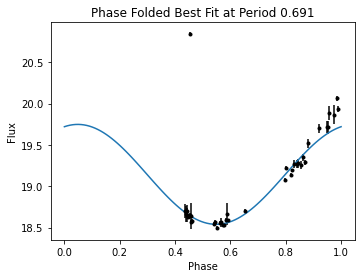

FITTING BEST PEFRIOD TO BAND z
PERIOD:  0.6908510241778698


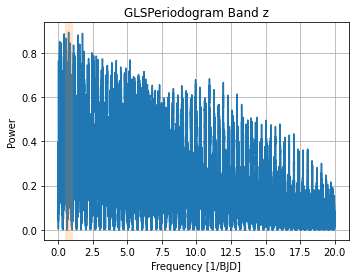

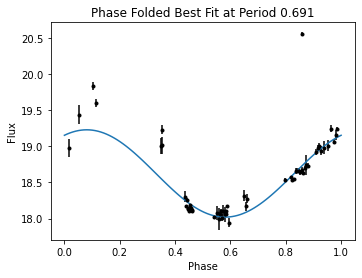

DC21tukg
ANALYZING GLS DATA FOR BAND g
FINISHED ANALYZING GLS DATA FOR BAND g
ANALYZING GLS DATA FOR BAND r
FINISHED ANALYZING GLS DATA FOR BAND r
ANALYZING GLS DATA FOR BAND i
FINISHED ANALYZING GLS DATA FOR BAND i
ANALYZING GLS DATA FOR BAND z
FINISHED ANALYZING GLS DATA FOR BAND z
ANALYZING REST OF DATA FOR BAND g
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:05:32 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:05:32 kbls:1143] minimum epoch is actually an array:
array([59346.35611074])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:05:32 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND g
ANALYZING REST OF DATA FOR BAND r
COMPUTING MHAOV
COMPUTING BLS


[W 220713 11:05:51 kbls:1120] multiple possible times-of-center transits found for period 0.5281573, picking the first one from: array([59304.3843792 , 59295.40597389])
[W 220713 11:05:51 kbls:1120] multiple possible times-of-center transits found for period 1.1229097, picking the first one from: array([59367.27912169, 59331.34902007])
[E 220713 11:05:51 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:05:51 kbls:1143] minimum epoch is actually an array:
array([59356.31737324])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.


COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND r
ANALYZING REST OF DATA FOR BAND i
COMPUTING MHAOV
COMPUTING BLS


[W 220713 11:06:10 kbls:1120] multiple possible times-of-center transits found for period 1.1225947, picking the first one from: array([59313.37200115, 59331.33468383])
[E 220713 11:06:10 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:06:10 kbls:1143] minimum epoch is actually an array:
array([59367.31063903])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:06:10 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perl

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND i
ANALYZING REST OF DATA FOR BAND z
COMPUTING MHAOV
COMPUTING BLS


[E 220713 11:06:29 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexError: index 0 is out of bounds for axis 0 with size 0
[W 220713 11:06:29 kbls:1143] minimum epoch is actually an array:
array([59714.29910858])
instead of a float, are there duplicate time values in the original input? will use the first value in this array.
[E 220713 11:06:29 kbls:1129] could not determine the center time of transit for the phased LC, trying SavGol fit instead...
Traceback (most recent call last):
  File "/global/homes/g/garimap/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/astrobase/periodbase/kbls.py", line 1125, in _get_bls_stats
    thisminepoch = me_centertransit_time[0]
IndexErro

COMPUTING PDM
FINISHED ANALYZING REST OF DATA FOR BAND z
[9.61338136574006, 9.57435948296671, 1.1230115045885998, 1.1198125865025608, 0.9077757392299907, 0.6965378462073731, 0.6403739600220913, 0.4193025065002328, 0.35916194911140376, 0.34568415769518784, 0.2951966356936531, 0.2640654150024782, 0.2951966356936531, 0.19560929207685487, 0.17963919061458722, 0.16954184840130487, 0.14490846173251845, 9.854359787182862, 9.813361235103658, 9.383907382960135, 2.2781736925154275, 2.2182026738586567, 1.7823791584628308, 0.8146579531554, 0.7232344588966594, 0.47522799457595294, 0.321862930304591, 0.38997802886013827, 0.2433343364902539, 0.23624221431649065, 0.22516909212065928, 0.21910342925044463, 0.18369634870384133, 0.1551859559711416, 0.13429052838531824, 0.12652513819412975, 0.11839002883594126, 0.19560929207685487, 0.09567568623480949, 10.064678251290536, 9.652797013475459, 9.094457862876814, 4.357083704076464, 4.357083704076464, 2.295913737020711, 2.282582952597061, 1.8265466944678617, 1.

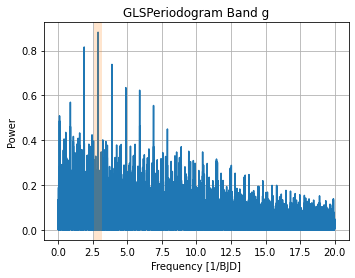

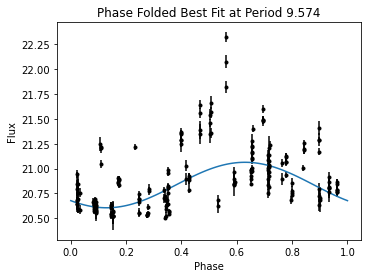

FITTING BEST PEFRIOD TO BAND r
PERIOD:  9.57435948296671


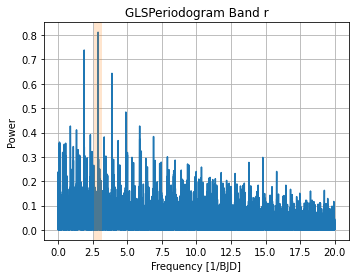

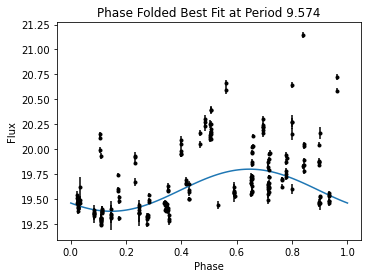

FITTING BEST PEFRIOD TO BAND i
PERIOD:  9.57435948296671


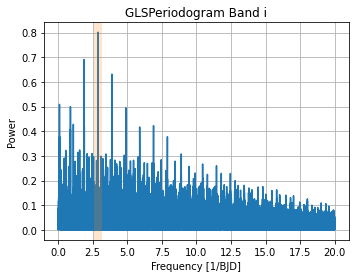

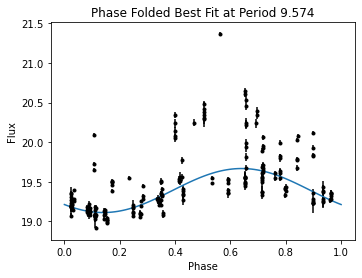

FITTING BEST PEFRIOD TO BAND z
PERIOD:  9.57435948296671


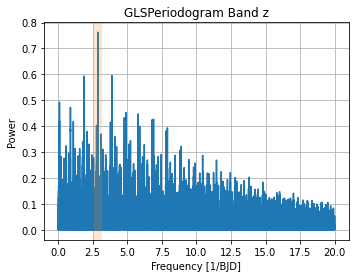

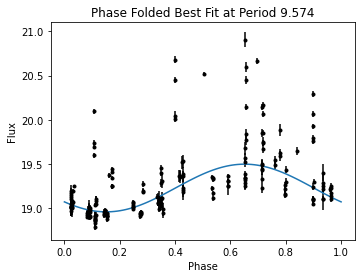

In [89]:
# Okay. NOW make this whole thing autonomous (famous last words)

for candidate in candidates[16:45]:
    print(candidate)
    df = pd.read_csv("data/" + candidate + " 1.csv")
    
    # print(df)
    periods_list = get_periods(df)
    # print(periods_list)
    if periods_list != []:
        best_fit_period = fap_minimization(df, periods_list)
        # best_fit_period = 0.22

        # Compute the GLS on Jayasinghe's frequency limits.
        frequency_min = 1/1000
        frequency_max = 1/0.05

        for band in bands:

            t, f, dg = get_band_ts(df, band)
            t = np.array(t.dropna())
            f = np.array(f.dropna())
            dg = np.array(dg.dropna())

            print("FITTING BEST PEFRIOD TO BAND " + band)
            ls = LombScargle(t, f, dg)
            frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)

            fig = plt.figure(figsize=(12, 4))
            ax = fig.add_subplot(1, 2, 1)
            ax.plot(frequency, power)
            ymin, ymax = ax.get_ylim()
            ax.plot([frequency[np.argmax(power)], frequency[np.argmax(power)]], [ymin, ymax], linewidth=8, alpha=0.2)
            ax.set_ylim([ymin, ymax])
            ax.set_xlabel('Frequency [1/BJD]')
            ax.set_ylabel('Power')
            plt.title('GLSPeriodogram Band ' + band)
            plt.grid()

            fit_peaks(best_fit_period, t, f, dg, ls)

FITTING BEST PEFRIOD TO BAND g


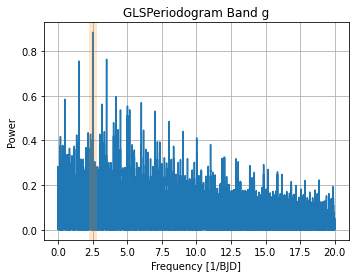

PERIOD:  0.2847623825073242


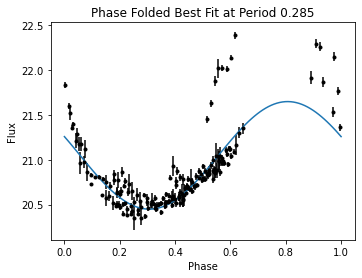

In [26]:
band = "g"
import matplotlib.pyplot as plt
%matplotlib inline

t, f, dg = get_band_ts(df, band)
t = np.array(t.dropna())
f = np.array(f.dropna())
dg = np.array(dg.dropna())

print("FITTING BEST PEFRIOD TO BAND " + band)
ls = LombScargle(t, f, dg)
frequency, power = ls.autopower(method='slow', minimum_frequency = frequency_min, maximum_frequency = frequency_max)

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(frequency, power)
ymin, ymax = ax.get_ylim()
ax.plot([frequency[np.argmax(power)], frequency[np.argmax(power)]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/BJD]')
ax.set_ylabel('Power')
plt.title('GLSPeriodogram Band ' + band)
plt.grid()
plt.show()

fit_peaks(best_fit_period, t, f, dg, ls)